# Associations between molecular and environmental changes along the proximal-to-distal axis of the colon
## Abstract
### Objective
Colorectal cancer is a heterogeneous disease, and tumours in the left or right sections of the colon are biologically disparate. The development of the two-colon paradigm, differentiating colorectal cancers according to their location relative to the splenic flexure, contributed to an improvement in prognosis and treatment. Recent studies challenged this division by proposing a continuum model where molecular properties follow a continuous trend along the colon. 
### Design
We address the question of which model describes CRC properties better by comparing their performance in describing the properties of colorectal tumours in a cohort of 522 patients from The Cancer Genome Atlas.
### Results
Results show that no model outperforms the other. Alterations affecting genes associated with growth are described better by the two-colon paradigm, while the continuum colon model better approximates alterations affecting genes related to metabolism and environment. As this suggests an environmental impact on changes in selective constraints along the colon, we chart the localised metabolome in a cohort of 27 colon cancer patients. Metabolites follow a continuous trend in agreement with other tissue-environmental factors such as microbiome. We show that genes with continuous transcriptional profiles interact with metabolites associated with carcinogenesis, suggesting that gradients of metabolism-mediated selective constraints might contribute to gradual changes in tumours along the colon.
### Conclusion
Our results question the previous left/right model of colon cancer, suggesting that an increase in the resolution of tumour localisation might better capture the biology of tumours as systems interacting with their local environment and holding clinical relevance.
### About this notebook
This notebook allow to reproduce all the results and figures presented in [CITAZIONE] 

# LOADING LIBRARIES

In [1]:
%matplotlib inline
import sys
sys.path.append("../../../git/lib") # Path to the profile_analysis_class.py lib
sys.path.append("/home/ieo5417/Documenti/git/network_analysis/lib/") # Path to the network_search_class.py lib
from profile_analysis_class import ProfileAnalysis # Import the profile workflow class
import pandas as pd
import matplotlib.pyplot as plt
from supervenn import supervenn
import mygene
from scipy.stats import chi2_contingency
from joblib import Parallel, delayed
from statsmodels.stats.multitest import fdrcorrection
import matplotlib
import os
import statistics
import numpy as np
import math
from scipy import stats
from scipy.stats import beta, norm
import scipy.stats
from scipy.stats import fisher_exact
import graph_tool as gt
import pyintergraph
from scipy.stats import mannwhitneyu
import collections

from network_search_class import NetworkSearchAnalysis

# Defining left and right sections
left_sections = ['Descending colon','Sigmoid colon','Rectosigmoid junction','Rectum, NOS']
right_sections = ['Cecum','Ascending colon','Hepatic flexure of colon','Transverse colon']

mg = mygene.MyGeneInfo()
plt.style.use('../../assets/styles/plotting_style.mplstyle') # Path to the matplotlib style sheet

In [24]:
def dLR(data, left_sec = 'Sigmoid colon', right_sec = 'Transverse colon'):
    # Create a dataframe with the selected section as right left sections
    dLR = pd.DataFrame(index=data.index)
    dLR['left']=data[{left_sec}]
    dLR['right']=data[{right_sec}]
    dLR['tcga_r/l']=dLR['right']/dLR['left']
    return dLR

def estimateT(median_exp, z=[2,1.5,1,0.5]):
    # Estimate the z-score threshold for high\low expression ratio by fitting a gaussian on GTEX
    mean=np.mean(median_exp)
    std=np.std(median_exp)
    ts = {}
    for value in z:
        hit=(value*std)+mean
        lowt=mean-(value*std)
        ts[value] = tuple([hit,lowt])
    return ts

def calculate_p(name, observable, background):
    p_value = 1-stats.percentileofscore(background,observable)/100
    return (name, p_value)

def calculate_p_beta(name, observable, background):
    a, b, loc, scale = beta.fit(background)
    p_value = 1-beta.cdf(observable, a, b, loc, scale)
    return (name, p_value)

def calculate_p_norm(name, observable, background):
    mu, std = norm.fit(background.astype('float'))
    p_value = 1-norm.cdf(observable, mu, std)
    return (name, p_value)

def calculate_q(p_table):
    q_table = pd.DataFrame(index=p_table.index)
    for column in p_table:
        no_na_col = p_table[column].dropna()
        q_values = pd.DataFrame(fdrcorrection(no_na_col)[1], columns=[column], index=no_na_col.index)
        q_table = pd.concat([q_table, q_values], axis=1)
    return q_table
        
def unzip_backgrounds(backgrounds_list):
    backgrounds = {}
    for df in backgrounds_list:
        name = df.columns[0].split('_')[0]
        background = []
        for column in df.columns:
            background = background + df[df[column]>0][column].to_list()
        backgrounds[name] = background
    return backgrounds

def select_significant_models(p_values, observables_scores):
    for key in p_values:
        if p_values[key][1] > 0.05:
            observables_scores.drop(key, axis=1, inplace=True)
    return observables_scores

def assemble_backgrounds(poly_obs_scores, sig_perm_scores, poly_perm_scores):
    backgrounds = {}
    for column in poly_obs_scores.columns:
        if column == 'sigmoidal':
            backgrounds[column] = sig_perm_scores
        else:
            backgrounds[column] = poly_perm_scores[column-1]
    return backgrounds

def get_p_values(poly_obs_scores, backgrounds):
    p_value_tables = pd.DataFrame(index=poly_obs_scores.index, columns=poly_obs_scores.columns)
    for index, row in poly_obs_scores.iterrows():
        for model in row.index:
            score = row[model]
            background = backgrounds[model].loc[index].dropna()
            result = calculate_p_norm(index, score, background)
#             result = calculate_p_beta(index, score, background)
            p_value_tables.loc[result[0], model] = result[1]
    return p_value_tables

def get_q_values(p_value_tables, poly_obs_scores):
    q_value_tables = pd.DataFrame(index=poly_obs_scores.index, columns=poly_obs_scores.columns)
    for column in p_value_tables:
        q_value_tables[column] = fdrcorrection(p_value_tables[column])[1]
    return q_value_tables

def classify_genes(observables_scores, q_values, q_tresh, sd):
    columns = []
    for column in observables_scores.columns:
        columns.append(str(column))
    observables_scores.columns = columns
    q_values.columns = columns

    models = {}
    for column in q_values:
        models[column] = list(q_values[q_values[column]<=q_tresh].index)

    q_by_model = pd.DataFrame()
    for key in models:
        q_by_model = pd.concat([q_by_model, q_values.loc[models[key]][key]], axis=1)
#     to_evaluate = q_by_model
#     if 'sigmoidal' in q_by_model.columns:
    to_evaluate = q_by_model.loc[q_by_model.dropna(subset=['sigmoidal']).index]
    continuous = q_by_model.drop(to_evaluate.index, axis=0)
    if 'sigmoidal' in q_by_model.columns:
        to_evaluate = q_by_model.dropna(subset=['sigmoidal'])
    #     for key in to_evaluate:
    #         to_evaluate[key] = to_evaluate[key]/statistics.median(q_by_model[key].dropna())
        polynomial_columns = [col for col in to_evaluate.columns if col != 'sigmoidal']
        to_evaluate.dropna(subset=polynomial_columns, how='all', inplace=True)
        sigmoid = q_by_model.drop(to_evaluate.index, axis=0)
        sigmoid = sigmoid.drop(continuous.index, axis=0)
        only_continuous = to_evaluate.drop('sigmoidal', axis=1)
        for index, row in only_continuous.iterrows():
            min_q = pd.to_numeric(row).idxmin()
            only_continuous.loc[index, only_continuous.columns != min_q] = np.nan
        for column in only_continuous.columns:
            only_continuous.iloc[:,0].fillna(only_continuous[column], inplace=True)    
        to_evaluate['continuous'] = only_continuous.iloc[:,0]
        to_evaluate = to_evaluate[['continuous', 'sigmoidal']]
        for index, row in to_evaluate.iterrows():
            to_evaluate.loc[index, 'ratio'] = abs(row['continuous']-row['sigmoidal'])/max([row['continuous'],row['sigmoidal']])
            to_evaluate.loc[index, 'best_q'] = pd.to_numeric(row).idxmin()
        discarded = list(to_evaluate[(to_evaluate['ratio']<sd)].index)
        to_evaluate = to_evaluate[to_evaluate['ratio']>sd]
        sigmoid = list(sigmoid.index)
    continuous = list(continuous.index)
    for index, row in to_evaluate.iterrows():
        if ('best_q' in row) and (row['best_q'] == 'sigmoidal'):
            sigmoid.append(index)
        else:
            continuous.append(index)
    classification = {}
    if 'sigmoidal' in q_by_model.columns:
        classification['sigmoid'] = sigmoid
        classification['discarded'] = discarded
    classification['continuous'] = continuous
    
    return classification

def plot_fitting_bars(gene_indexes_list, medians, mad, poly_models, save_as='', plot_fit=True, ylabel='', title=True, set_lim=[], plot_mad=True):
        model = 'continuum'
        degree = 1
        medianprops = dict(linestyle='None')
        boxprops = dict(linestyle='-', linewidth=1.5, color='k')
        if (len(gene_indexes_list) % 2 != 0):
            vertical = len(gene_indexes_list)//2+1
        else:
            vertical = len(gene_indexes_list)//2
        h = 0
        l = 0
        plt.figure(figsize=(20, 10*vertical))
        if 'Unnamed: 0' in mad.columns:
            mad.set_index('Unnamed: 0', inplace=True)
        for key in gene_indexes_list:
            x = np.linspace(pa_transcriptome.x[0], pa_transcriptome.x[-1], 1000)
            axs = plt.subplot2grid((vertical, 2), (h, l))
            if plot_mad:
                plt.bar(pa_transcriptome.x, list(medians.loc[key,:]),yerr=list(mad.loc[key,:]), color='grey', edgecolor='k')
            else:
                plt.bar(pa_transcriptome.x, list(medians.loc[key,:]), color='grey', edgecolor='k')
            gene_dist = []
            y = np.polynomial.polynomial.polyval(x, poly_models[degree][key])
            plt.plot(x, y, color='red', ls='-', linewidth=2)
            plt.title(f'{key}')
            if set_lim:
                plt.ylim(set_lim)
            plt.xticks(ticks=pa_transcriptome.x, labels=pa_transcriptome.sections4plots, rotation=45, ha='right', fontsize=22)
            plt.ylabel(ylabel, fontsize=22)
            l = l+1
            if l == 2:
                h = h+1
                l = 0
        plt.tight_layout()
        if save_as:
            plt.savefig('/'.join([pa_transcriptome.figures, f'{save_as}']), format="svg")
        plt.show()

# TRANSCRIPTOME PROFILING

In [25]:
# Create workflow class, specifying the path to the SETTINGS.ini file
pa_transcriptome = ProfileAnalysis('../../../docker/analysis/transcriptome')

Project has been created!


/home/ieo5417/Documenti/colon_paper/git/notebooks/paper_analysis/../../../git/lib/profile_analysis_class.py:156: UserWarning: Folder input_data already exist...skipping
  warnings.warn("Folder input_data already exist...skipping",
/home/ieo5417/Documenti/colon_paper/git/notebooks/paper_analysis/../../../git/lib/profile_analysis_class.py:162: UserWarning: Folder data_raw already exist...skipping
  warnings.warn("Folder data_raw already exist...skipping",
/home/ieo5417/Documenti/colon_paper/git/notebooks/paper_analysis/../../../git/lib/profile_analysis_class.py:168: UserWarning: Folder data_clinical already exist...skipping
  warnings.warn("Folder data_clinical already exist...skipping",
/home/ieo5417/Documenti/colon_paper/git/notebooks/paper_analysis/../../../git/lib/profile_analysis_class.py:174: UserWarning: Folder sample_by_section already exist...skipping
  warnings.warn("Folder sample_by_section already exist...skipping",
/home/ieo5417/Documenti/colon_paper/git/notebooks/paper_anal

## Assign each sample in clinical data file to a colon section

In [26]:
pa_transcriptome.create_samples_to_sections_table()

## Calculate median value and median average variation for each colon section

In [27]:
medians_tr, mad_tr = pa_transcriptome.median_by_section()

This step has already been executed...loading results...
This step has already been executed...loading results...


In [ ]:
gtex.head()

In [31]:
# The following code calculate the right/left ratio for GTEX and TCGA expression data
# and use this ratio to estimate threshold of high and low expression ratio

# To save execution time the GTEX file have already been generated
# To regenerate the file just delete it ('../docker/analysis/gtex/gtex_right_left_diff.csv')
if not os.path.isfile('../../../docker/analysis/gtex/gtex_right_left_diff.csv'):
    # Load GTEX data
    gtex=pd.read_csv('../../../docker/analysis/gtex/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gzip', compression='gzip')
    gtex.set_index('Name', inplace=True)
    # Load GTEX clinical data
    gtex_clinical=pd.read_csv('../../../docker/analysis/gtex/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt', sep='\t')
    gtex_clinical.set_index('SAMPID', inplace=True)
    # Discard samples for which we don't have data
    mask = [index for index in gtex_clinical.index if index in gtex.columns]
    gtex_clinical = gtex_clinical.loc[mask]
    # Classify samples as left or right
    gtex_samples2sections={}
    gtex_samples2sections['left']=gtex_clinical[gtex_clinical['SMTSD']=='Colon - Sigmoid'].index
    gtex_samples2sections['right']=gtex_clinical[gtex_clinical['SMTSD']=='Colon - Transverse'].index
    # Calculate left and right median expression for each gene
    gtex_data=pd.DataFrame()
    for index, row in gtex.iterrows():
        gtex_data.loc[index, 'left']=statistics.median(row[gtex_samples2sections['left']])
        gtex_data.loc[index, 'right']=statistics.median(row[gtex_samples2sections['right']])
    # Remove the .XX part of ensmbl id
    gtex_lr=pd.DataFrame(columns=gtex_data.columns)
    for index in gtex_data.index:
        gtex_lr.loc[index.split('.')[0]]=gtex_data.loc[index]
    # calculate GTEX RIGHT/LEFT ratio for each gene
    gtex_lr['gtex_r/l'] = (gtex_lr['right'])/(gtex_lr['left'])
    # Drop na (happens when left TPM counts are 0)
    gtex_lr.dropna(inplace=True)
    # Save file for future
    gtex_lr.index.name = 'ensmbl'
    gtex_lr.to_csv('../../../docker/analysis/gtex/gtex_right_left_diff.csv')
else:
    gtex_lr = pd.read_csv('../../../docker/analysis/gtex/gtex_right_left_diff.csv')
    gtex_lr.set_index('ensmbl', inplace=True)

# calculate right/left ratio in TCGA data
medians_lr = dLR(medians_tr)

# Merge GTEX and TCGA, drop inf and na values
gtex_tcga = pd.concat([medians_lr['tcga_r/l'],gtex_lr['gtex_l-r']], axis=1)
gtex_tcga.replace([np.inf, -np.inf], np.nan, inplace=True)
gtex_tcga.dropna(inplace=True)

# Estimate the z-score threshold for high\low expression ratio by fitting a gaussian on TCGA data
ts_tcga = estimateT(gtex_tcga['tcga_r/l'])

# Select continuous genes inside the top left and bottom right panels of previous plot
# they correspond to high/low ratio GTEX vs TCGA and low/high ratio GTEX vs TCGA
ds_tcga=0.5
ds_gtex=1
tcga_std_filter = [feature for feature in gtex_tcga['tcga_r/l'].index
                   if gtex_tcga['tcga_r/l'][feature]>ts_tcga[ds_tcga][0] 
                   or gtex_tcga['tcga_r/l'][feature]<ts_tcga[ds_tcga][1]]
gtex_filter = [feature for feature in tcga_std_filter 
               if gtex_tcga['gtex_l-r'][feature]<ts_tcga[ds_gtex][0] 
               and gtex_tcga['gtex_l-r'][feature]>ts_tcga[ds_gtex][1]]

# medians_tr = medians_tr.loc[gtex_filter]

<ipython-input-2-30f4444d974f>:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dLR['left']=data[{left_sec}]
<ipython-input-2-30f4444d974f>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dLR['right']=data[{right_sec}]


In [59]:
gtex=pd.read_csv('../../../docker/analysis/gtex/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gzip', compression='gzip')
gtex.set_index('Name', inplace=True)
# Load GTEX clinical data
gtex_clinical=pd.read_csv('../../../docker/analysis/gtex/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt', sep='\t')
gtex_clinical.set_index('SAMPID', inplace=True)
# Discard samples for which we don't have data
mask = [index for index in gtex_clinical.index if index in gtex.columns]
gtex_clinical = gtex_clinical.loc[mask]
# Classify samples as left or right
gtex_samples2sections={}
gtex_samples2sections['left']=gtex_clinical[gtex_clinical['SMTSD']=='Colon - Sigmoid'].index
gtex_samples2sections['right']=gtex_clinical[gtex_clinical['SMTSD']=='Colon - Transverse'].index

In [61]:
gtex_samples2sections['left']

Index(['GTEX-111CU-1226-SM-5EGIN', 'GTEX-111YS-1826-SM-5GIEP',
       'GTEX-1122O-1426-SM-5H11R', 'GTEX-117XS-2226-SM-5GIE1',
       'GTEX-117YX-0526-SM-5EGJH', 'GTEX-11DXX-1926-SM-5EGJK',
       'GTEX-11DXY-2026-SM-5N9CZ', 'GTEX-11DXZ-1626-SM-5GIDI',
       'GTEX-11EI6-2626-SM-5PNVT', 'GTEX-11EM3-1626-SM-5N9CO',
       ...
       'GTEX-ZVT3-2826-SM-5GU6A', 'GTEX-ZVT4-2626-SM-5N9GJ',
       'GTEX-ZVZQ-2626-SM-59HLB', 'GTEX-ZXES-1726-SM-5E43G',
       'GTEX-ZY6K-1326-SM-5GZWP', 'GTEX-ZYFD-2226-SM-5E43P',
       'GTEX-ZYFG-1826-SM-5GZWX', 'GTEX-ZYT6-2826-SM-5GICX',
       'GTEX-ZYY3-2226-SM-5E45A', 'GTEX-ZZ64-0826-SM-5E449'],
      dtype='object', name='SAMPID', length=373)

In [65]:
gtex.drop(['Description'], axis=1, inplace=True)

In [ ]:
indexes=[]
for index in gtex.index:
    if not index.split('.')[0] in list(table.index):
        gtex.drop(index, axis=0, inplace=True)
    else:
        indexes.append(index.split('.')[0])

In [93]:
from scipy.stats import mannwhitneyu
gtex_wilcoxon = pd.DataFrame(index=gtex.index)
for index, row in gtex.iterrows():
    x = list(gtex.loc[index, gtex_samples2sections['left']])
    y = list(gtex.loc[index, gtex_samples2sections['right']])
    stat, p = mannwhitneyu(x, y)
    gtex_wilcoxon.loc[index, 'p-value mannwhitney'] = p
# gtex.loc[:,gtex_samples2sections['left']]

In [94]:
gtex_wilcoxon['q-value mannwhitney'] = fdrcorrection(gtex_wilcoxon['p-value mannwhitney'])[1]

In [96]:
gtex_wilcoxon

,p-value mannwhitney,q-value mannwhitney
Name,,
ENSG00000187634.11,4.071505e-02,7.083631e-02
ENSG00000188976.10,1.373350e-19,5.560851e-19
ENSG00000187961.13,4.108793e-12,1.288844e-11
ENSG00000187583.10,1.461236e-55,4.437211e-54
ENSG00000187642.9,2.553993e-05,5.980784e-05
...,...,...
ENSG00000198695.2,5.486441e-05,1.257504e-04
ENSG00000210194.1,3.797670e-05,8.789523e-05
ENSG00000198727.2,3.300864e-03,6.588861e-03


In [97]:
gtex_wilcoxon.to_csv('correction.csv')

In [98]:
gtex_wilcoxon = pd.read_csv('/home/ieo5417/Documenti/colon_paper/git/notebooks/paper_analysis/correction.csv')
gtex_wilcoxon.set_index('Name', inplace=True)

In [99]:
gtex_wilcoxon

,p-value mannwhitney,q-value mannwhitney
Name,,
ENSG00000187634,4.071505e-02,7.083631e-02
ENSG00000188976,1.373350e-19,5.560851e-19
ENSG00000187961,4.108793e-12,1.288844e-11
ENSG00000187583,1.461236e-55,4.437211e-54
ENSG00000187642,2.553993e-05,5.980784e-05
...,...,...
ENSG00000198695,5.486441e-05,1.257504e-04
ENSG00000210194,3.797670e-05,8.789523e-05
ENSG00000198727,3.300864e-03,6.588861e-03


In [100]:
table.merge(gtex_wilcoxon, left_index=True, right_index=True, how='left').to_csv('transcriptomic_table.csv')

In [28]:
protein_coding_genes = pd.read_csv('/home/ieo5417/Documenti/colon_paper/docker/analysis/transcriptome/output/protein-coding_gene.txt', sep='\t')
protein_coding_genes.set_index('ensembl_gene_id', inplace=True)

<ipython-input-28-c80664b77a54>:1: DtypeWarning: Columns (31,38) have mixed types. Specify dtype option on import or set low_memory=False.
  protein_coding_genes = pd.read_csv('/home/ieo5417/Documenti/colon_paper/docker/analysis/transcriptome/output/protein-coding_gene.txt', sep='\t')


In [29]:
for index, row in medians_tr.iterrows():
    if not index in protein_coding_genes.index:
        medians_tr.drop(index, axis=0, inplace=True)

In [30]:
medians_tr

,Cecum,Ascending colon,Hepatic flexure of colon,Transverse colon,Descending colon,Sigmoid colon,Rectosigmoid junction,"Rectum, NOS"
ensmbl_id,,,,,,,,
ENSG00000000003,73.907526,78.403451,103.124233,75.913878,82.543993,132.823036,133.446046,100.606220
ENSG00000000005,1.008409,0.735658,1.336772,0.798797,1.680453,1.657560,1.893015,1.379483
ENSG00000000419,99.851076,104.284560,117.657759,97.626225,154.401872,170.663164,139.689173,144.105845
ENSG00000000457,6.921388,6.640371,7.004861,7.278464,7.113812,7.131714,7.116130,6.885216
ENSG00000000460,5.263295,4.969358,5.424937,4.844178,6.057782,5.991615,5.782876,6.181672
...,...,...,...,...,...,...,...,...
ENSG00000279170,0.085090,0.087946,0.087270,0.055078,0.103207,0.069108,0.070744,0.083611
ENSG00000280670,2.599871,2.737009,2.670877,3.180451,2.637739,2.673590,2.607825,2.764748
ENSG00000280789,14.683333,12.651212,14.304820,13.621925,14.644178,14.223249,11.548325,13.004322


In [34]:
query = mg.querymany(set(medians_tr.index),
                    scopes='ensembl.gene',
                    species=9606,
                    fields='symbol',
                    returnall=True,
                    as_dataframe=True)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-16116...done.
Finished.
2 input query terms found no hit:
	['ENSG00000168078', 'ENSG00000189144']


In [43]:
table = query['out'].copy()
table.drop(['_id', '_score', 'notfound'], axis=1, inplace=True)

In [44]:
for index in table.index:
    if index in list(protein_coding_genes.index):
        table.loc[index,'protein_coding'] = 'yes'
    else:
        table.loc[index,'protein_coding'] = 'no'

In [45]:
for index, row in table.iterrows():
    if index in classification_tr['continuous']:
        table.loc[index,'profile'] = 'continuous'
    elif index in classification_tr['sigmoid']:
        table.loc[index,'profile'] = 'sigmoid'
    else:
        table.loc[index,'profile'] = 'unclassified'

In [47]:
p_value_cont=pd.DataFrame(index=p_value_tables_tr.index)
p_values_sig=p_value_tables_tr[['sigmoidal']]
p_values_sig.columns=['p-value sigmoid']
for index, row in p_value_tables_tr[[1,2,3]].iterrows():
    p_value_cont.loc[index,'p-value continuous'] = min(row)
table = table.merge(p_value_cont, left_index=True, right_index=True)
table = table.merge(p_values_sig, left_index=True, right_index=True)

In [81]:
table

,symbol,protein_coding,profile,p-value continuous,p-value sigmoid,q-value continuous,q-value sigmoid,gtex r/l
ENSG00000115947,ORC4,yes,unclassified,0.336268,0.629047,0.814318,0.939858,0.805996
ENSG00000189377,CXCL17,yes,sigmoid,0.005038,0.000978,0.040054,0.0125,1.178670
ENSG00000133835,HSD17B4,yes,unclassified,0.140587,0.677408,0.440626,0.94874,1.270107
ENSG00000136717,BIN1,yes,unclassified,0.062491,0.460819,0.250178,0.823344,0.695421
ENSG00000139364,TMEM132B,yes,unclassified,0.121026,0.077223,0.398051,0.247813,0.410129
...,...,...,...,...,...,...,...,...
ENSG00000110680,CALCA,yes,unclassified,0.394661,0.659318,0.827202,0.948228,0.336334
ENSG00000141934,PLPP2,yes,unclassified,0.474191,0.177032,0.846877,0.44977,14.599683
ENSG00000131061,ZNF341,yes,unclassified,0.345073,0.737542,0.769016,0.938049,0.821000
ENSG00000139428,MMAB,yes,unclassified,0.736118,0.759308,0.846877,0.930263,0.989775


In [49]:
q_value_cont=pd.DataFrame(index=q_value_tables_tr.index)
q_values_sig=q_value_tables_tr[['sigmoidal']]
q_values_sig.columns=['q-value sigmoid']
for index, row in q_value_tables_tr[['1','2','3']].iterrows():
    q_value_cont.loc[index,'q-value continuous'] = min(row)
table = table.merge(q_value_cont, left_index=True, right_index=True)
table = table.merge(q_values_sig, left_index=True, right_index=True)

In [55]:
for index, row in table.iterrows():
    if index in list(gtex_tcga.index):
        table.loc[index, 'gtex r/l'] = gtex_tcga.loc[index, 'gtex_l-r']

In [56]:
table

,symbol,protein_coding,profile,p-value continuous,p-value sigmoid,q-value continuous,q-value sigmoid,gtex r/l
ENSG00000115947,ORC4,yes,unclassified,0.336268,0.629047,0.814318,0.939858,0.805996
ENSG00000189377,CXCL17,yes,sigmoid,0.005038,0.000978,0.040054,0.0125,1.178670
ENSG00000133835,HSD17B4,yes,unclassified,0.140587,0.677408,0.440626,0.94874,1.270107
ENSG00000136717,BIN1,yes,unclassified,0.062491,0.460819,0.250178,0.823344,0.695421
ENSG00000139364,TMEM132B,yes,unclassified,0.121026,0.077223,0.398051,0.247813,0.410129
...,...,...,...,...,...,...,...,...
ENSG00000110680,CALCA,yes,unclassified,0.394661,0.659318,0.827202,0.948228,0.336334
ENSG00000141934,PLPP2,yes,unclassified,0.474191,0.177032,0.846877,0.44977,14.599683
ENSG00000131061,ZNF341,yes,unclassified,0.345073,0.737542,0.769016,0.938049,0.821000
ENSG00000139428,MMAB,yes,unclassified,0.736118,0.759308,0.846877,0.930263,0.989775


In [ ]:
results.to_csv('transcriptomic_table.csv')

In [ ]:
protein_coding_genes

In [ ]:
# Correlation plot right/left ratio in TCGA vs GTEX
# %matplotlib inline
plt.figure(figsize=(10,10))
plt.scatter(gtex_tcga['tcga_r/l'], gtex_tcga['gtex_l-r'])
# cont_old_filtered = [gene for gene in cont_old+sig_old if gene in gtex_tcga.index]

plt.scatter(gtex_tcga.loc[gtex_filter, 'tcga_r/l'], gtex_tcga.loc[gtex_filter, 'gtex_l-r'], color='r', label= 'Genes analyzed')
# plt.scatter(gtex_tcga.loc['ENSG00000134982', 'tcga_r/l'], gtex_tcga.loc['ENSG00000134982', 'gtex_l-r'], color='y')
# plt.scatter(gtex_tcga.loc[sig_old]['tcga_r/l'], gtex_tcga.loc[sig_old]['gtex_l-r'], edgecolors='k', color='g', label='Sigmoid')
# plt.scatter(gtex_tcga.loc[cont_old_filtered]['tcga_r/l'], gtex_tcga.loc[cont_old_filtered]['gtex_l-r'], edgecolors='k', color='y', label='Previous continuous set')
gtex_filter
# plt.scatter(gtex_tcga.loc[sc_z2_values]['tcga_l-r'], gtex_tcga.loc[sc_z2_values]['gtex_l-r'], color='r')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('GTEX Right/Left Ratio')
plt.xlabel('TCGA Right/Left Ratio')
plt.legend(loc = 'upper left')
colors =['r','g','b']
z_tcga=0.5
z_gtex=1
i=0
#Blue line is [1,1], red line correspond to z=2 in the previous plot
for key in ts_tcga:
    plt.axvline(x=ts_tcga[z_tcga][1], color='k', linestyle='-')
    plt.axvline(x=ts_tcga[z_tcga][0], color='k', linestyle='-')
#     plt.axhline(y=1, color='b', linestyle='-')
    plt.axhline(y=ts_tcga[z_gtex][1], color='r', linestyle='-')
    plt.axhline(y=ts_tcga[z_gtex][0], color='r', linestyle='-')
#     plt.axhline(y=ts[1.5][1], color='b', linestyle='-')
    i=i+1
plt.tight_layout()
plt.savefig('filtering_output.svg', format='svg')

## Fit Observables

In [31]:
scores_tr, poly_obs_scores_tr, sig_obs_scores_tr, poly_models_tr, sig_models_tr = pa_transcriptome.fit_data(medians_tr, guess_bounds = True)

This step has already been executed...loading results...
This step has already been executed...loading results...
This step has already been executed...loading results...
This step has already been executed...loading results...


## Fit Random permutated data

In [32]:
poly_perm_scores_tr, sig_perm_scores_tr, sig_perm_models_tr = pa_transcriptome.fit_random_data(medians_tr, guess_bounds = True)

This step has already been executed...loading results...
This step has already been executed...loading results...
This step has already been executed...loading results...


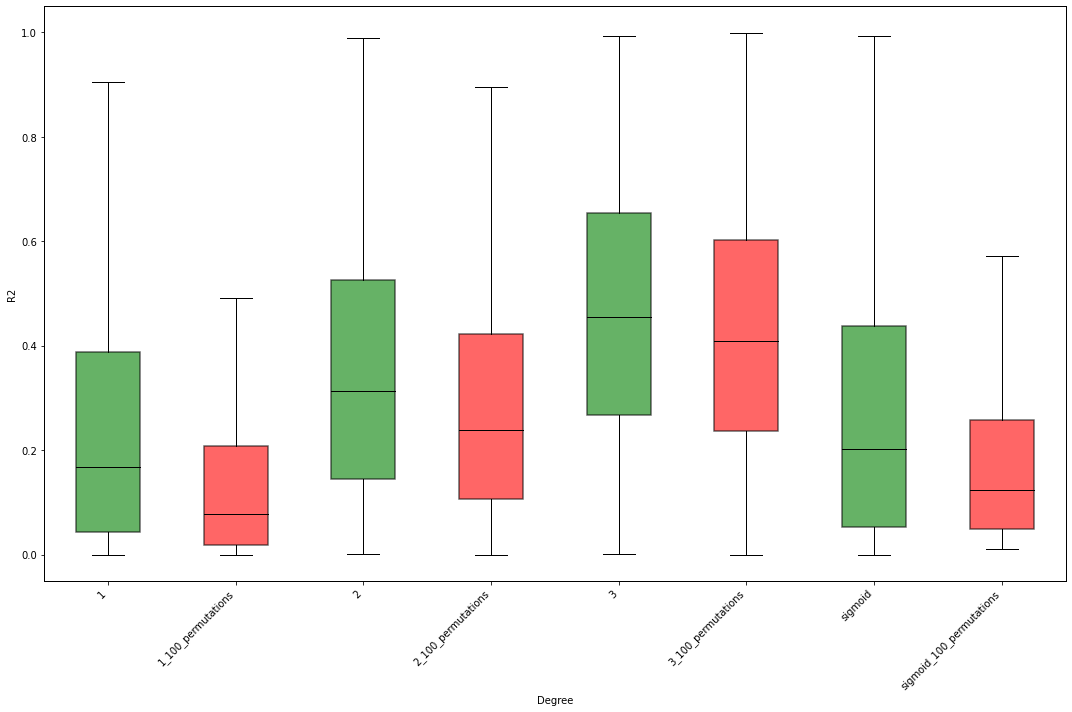

/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


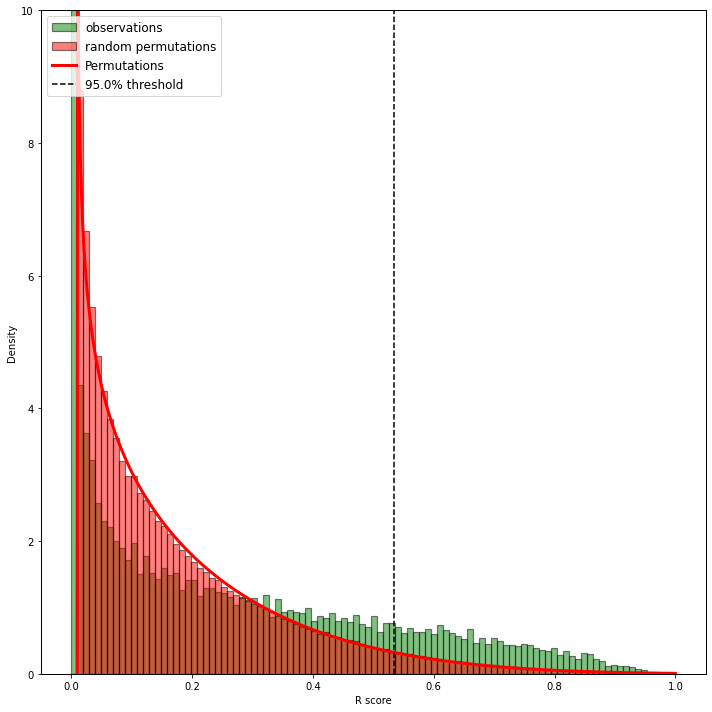

/home/ieo5417/.local/lib/python3.8/site-packages/statsmodels/stats/multitest.py:327: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha
/home/ieo5417/.local/lib/python3.8/site-packages/statsmodels/stats/multitest.py:333: RuntimeWarning: invalid value encountered in accumulate
  pvals_corrected = np.minimum.accumulate(pvals_corrected_raw[::-1])[::-1]
/home/ieo5417/.local/lib/python3.8/site-packages/statsmodels/stats/multitest.py:335: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1
/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


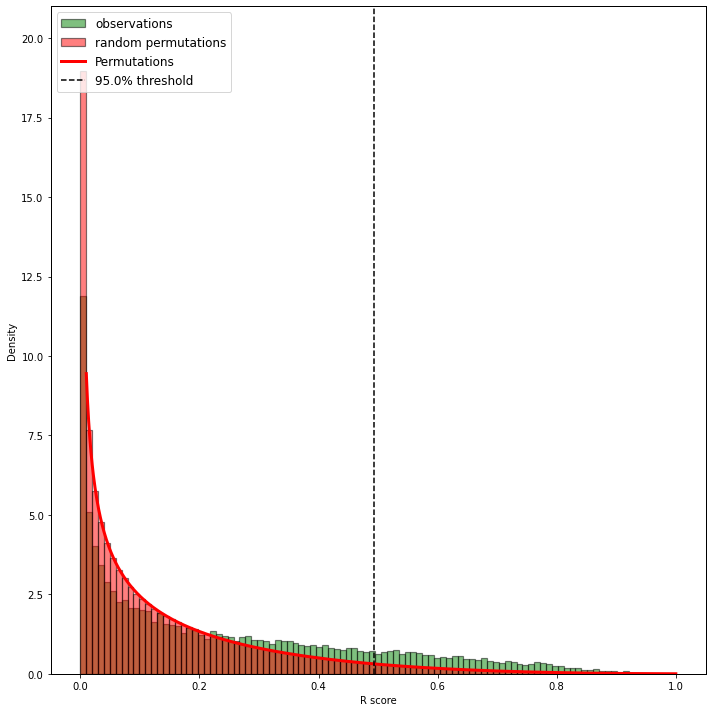

/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


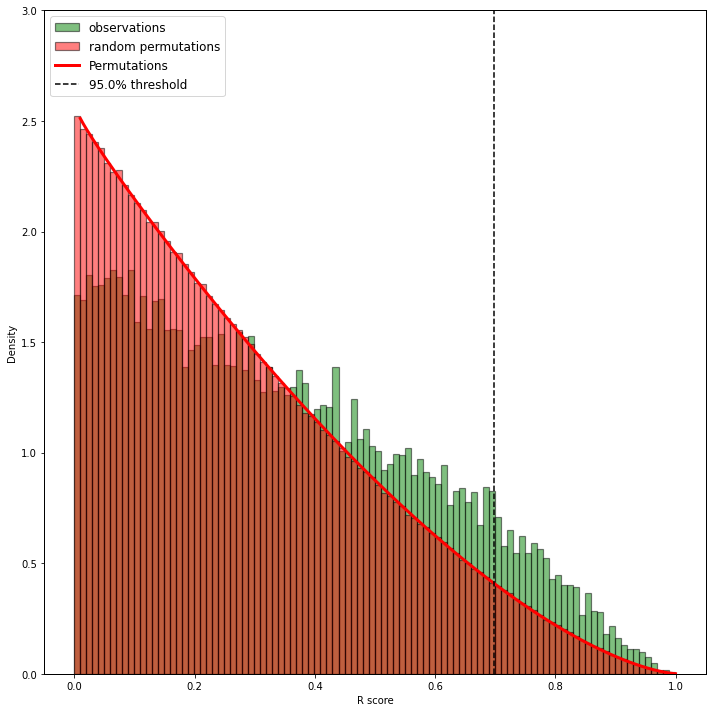

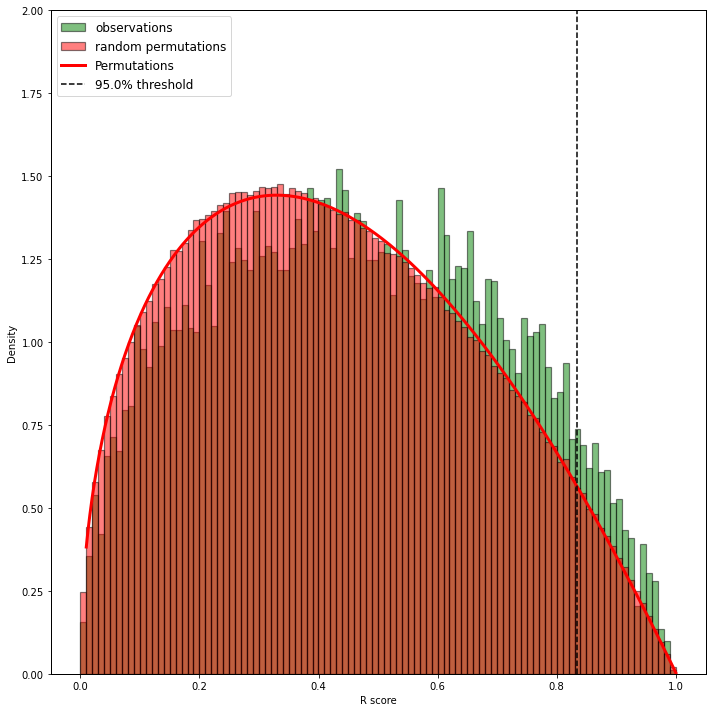

In [33]:
%matplotlib inline
models_pvalue_tr, scores_table=pa_transcriptome.plot_gof(poly_obs_scores_tr, sig_obs_scores_tr, poly_perm_scores_tr, sig_perm_scores_tr, dist_perm=True)

In [ ]:
models_pvalue_tr

In [34]:
models_pvalue_tr

{'sigmoidal': [11749924083.0, 2.3388941430258802e-273, 0.5348114488044351],
 1: [16303849953.0, 0.0, 0.493274250792594],
 2: [15006501680.0, 3.218114556044919e-254, 0.6983583810555937],
 3: [14145747377.0, 2.787532452666831e-85, 0.8338270566797528]}

In [35]:
poly_obs_scores_tr = select_significant_models(models_pvalue_tr, poly_obs_scores_tr)

In [36]:
backgrounds_tr = assemble_backgrounds(poly_obs_scores_tr, sig_perm_scores_tr, poly_perm_scores_tr)

In [37]:
p_value_tables_tr = get_p_values(poly_obs_scores_tr, backgrounds_tr)

In [38]:
q_value_tables_tr = get_q_values(p_value_tables_tr, poly_obs_scores_tr)

/home/ieo5417/.local/lib/python3.8/site-packages/statsmodels/stats/multitest.py:327: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha
/home/ieo5417/.local/lib/python3.8/site-packages/statsmodels/stats/multitest.py:333: RuntimeWarning: invalid value encountered in accumulate
  pvals_corrected = np.minimum.accumulate(pvals_corrected_raw[::-1])[::-1]
/home/ieo5417/.local/lib/python3.8/site-packages/statsmodels/stats/multitest.py:335: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1


In [39]:
backgrounds_tr_str = {}
for key in backgrounds_tr.keys():
    backgrounds_tr_str[str(key)] = backgrounds_tr[key]

In [40]:
backgrounds_all_scores_dist = {}
for key in backgrounds_tr_str:
    temp = []
    for column in backgrounds_tr_str[key]:
        temp = temp + list(backgrounds_tr_str[key][column])
    backgrounds_all_scores_dist[str(key)] = temp

In [41]:
classification_tr = classify_genes(poly_obs_scores_tr, q_value_tables_tr, 0.1, 0.1)

<ipython-input-24-c0993c4dfdd5>:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_evaluate.dropna(subset=polynomial_columns, how='all', inplace=True)
<ipython-input-24-c0993c4dfdd5>:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_evaluate['continuous'] = only_continuous.iloc[:,0]


In [42]:
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in classification_tr.items() ])).to_csv('classification_tr.csv')

In [43]:
for key in classification_tr:
    print(key)
    print(len(classification_tr[key]))

sigmoid
2238
discarded
72
continuous
2173


In [52]:
import sympy as sym
section_l = []
gene_list = []
x = sym.Symbol('x')
x0 = sym.Symbol('x0')
y0 = sym.Symbol('y0')
c = sym.Symbol('c')
k = sym.Symbol('k')
f = c / (1 + sym.exp(-k*(x-x0))) + y0
f_prime = f.diff(x)
f_prime = sym.lambdify([(x, x0, y0, c, k)], f_prime)
x = np.linspace(pa_transcriptome.x[0], pa_transcriptome.x[-1], 10000)
plt.figure(figsize=(10, 10))
d_ = []
for i in x:
    d_.append(abs(f_prime(np.insert(sig_models_tr['ENSG00000000003'],1,i))))
index_min = np.argmax(d_)

<lambdifygenerated-5>:3: RuntimeWarning: overflow encountered in exp
  return (c*k*exp(-k*(x - x0))/(1 + exp(-k*(x - x0)))**2)
<lambdifygenerated-5>:3: RuntimeWarning: invalid value encountered in double_scalars
  return (c*k*exp(-k*(x - x0))/(1 + exp(-k*(x - x0)))**2)
<lambdifygenerated-5>:3: RuntimeWarning: overflow encountered in double_scalars
  return (c*k*exp(-k*(x - x0))/(1 + exp(-k*(x - x0)))**2)


<Figure size 720x720 with 0 Axes>

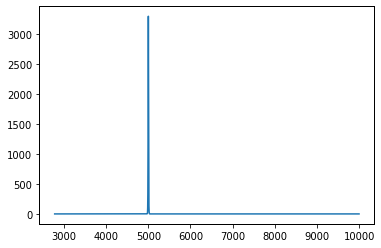

In [53]:
plt.plot(d_)

In [51]:
pa_transcriptome.x

[1, 2, 3, 4, 5, 6, 7, 8]

In [50]:
np.linspace(pa_transcriptome.x[0], pa_transcriptome.x[-1], 10000)

array([1.        , 1.00070007, 1.00140014, ..., 7.99859986, 7.99929993,
       8.        ])

In [32]:
list(pa_transcriptome.sections.keys())[int(round(x[index_min]))-1]

'Sigmoid colon'

In [40]:
pa_transcriptome.x[0]

1

In [43]:
list(pa_transcriptome.sections.keys())[round(x[index_min])-1]

'Sigmoid colon'

In [44]:
pa_transcriptome.sections

{'Cecum': ['Cecum'],
 'Ascending colon': ['Ascending colon'],
 'Hepatic flexure of colon': ['Hepatic flexure of colon'],
 'Transverse colon': ['Transverse colon'],
 'Descending colon': ['Descending colon', 'Splenic flexure of colon'],
 'Sigmoid colon': ['Sigmoid colon'],
 'Rectosigmoid junction': ['Rectosigmoid junction'],
 'Rectum, NOS': ['Rectum, NOS']}

In [33]:
pa_transcriptome.sections.keys()

dict_keys(['Cecum', 'Ascending colon', 'Hepatic flexure of colon', 'Transverse colon', 'Descending colon', 'Sigmoid colon', 'Rectosigmoid junction', 'Rectum, NOS'])

## SF 1A

<lambdifygenerated-1>:3: RuntimeWarning: overflow encountered in exp
  return (c*k*exp(-k*(x - x0))/(1 + exp(-k*(x - x0)))**2)
<lambdifygenerated-1>:3: RuntimeWarning: invalid value encountered in double_scalars
  return (c*k*exp(-k*(x - x0))/(1 + exp(-k*(x - x0)))**2)
<lambdifygenerated-1>:3: RuntimeWarning: overflow encountered in double_scalars
  return (c*k*exp(-k*(x - x0))/(1 + exp(-k*(x - x0)))**2)


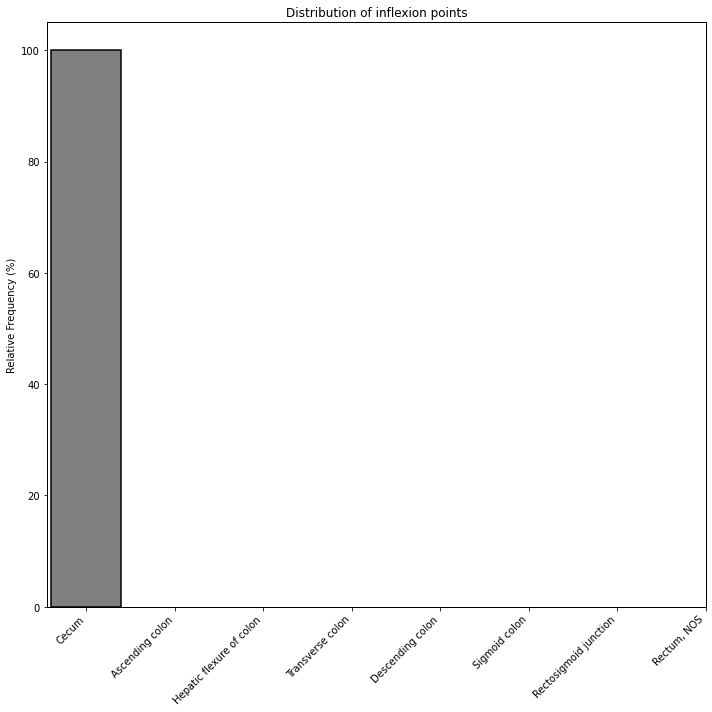

In [22]:
gene_list_tr, section_l_tr = pa_transcriptome.strict_sig_list(classification_tr['sigmoid'], sig_models_tr, plot_dist = True)

In [25]:
len(classification_tr['sigmoid'])

2868

## Figure 1D

In [ ]:
pa_transcriptome.plot_fitting_bars(classification_tr['sigmoid'], ['ENSG00000036257',
'ENSG00000037042',
'ENSG00000037757',
'ENSG00000038295',
'ENSG00000039650',
'ENSG00000046653',
'ENSG00000047249',
'ENSG00000047578',
'ENSG00000047617',
'ENSG00000048140',
'ENSG00000048342',
'ENSG00000048405',
'ENSG00000049249',
'ENSG00000049449',
'ENSG00000049769',
'ENSG00000050344',
'ENSG00000050730',
'ENSG00000051620',
'ENSG00000053371',
'ENSG00000053438',
'ENSG00000053501',
'ENSG00000053702',
'ENSG00000055070',
'ENSG00000055483',
'ENSG00000055917',
'ENSG00000056097',
'ENSG00000059378',
'ENSG00000060688',
'ENSG00000060709',
'ENSG00000063241',
'ENSG00000063244',
'ENSG00000064042',
'ENSG00000064218',
'ENSG00000064313',
'ENSG00000064490',
'ENSG00000064666',
'ENSG00000064763',
'ENSG00000065057',
'ENSG00000065361',
'ENSG00000065457',
'ENSG00000065548',
'ENSG00000065559',
'ENSG00000065600',
'ENSG00000065989',
'ENSG00000066248',
'ENSG00000066777',
'ENSG00000067221',
'ENSG00000067365',
'ENSG00000067533',
'ENSG00000068078',
'ENSG00000068878',
'ENSG00000069011',
'ENSG00000069248',
'ENSG00000069329',
'ENSG00000069431'],
                                   medians_tr,
                                   mad_tr,
                                   poly_models_tr, sig_models_tr,
                                   'sigmoid',
                                   title=False,
                                   save_as='Figure_1D.svg')

# Testing enrichment in oxygen-continuous genes CTD database

In [ ]:
# Load Colorectal cancer neoplasms interactions and select Oxygen
colorectal_neoplasm_interactions = pd.read_csv('/home/ieo5417/Documenti/colon_paper/docker/analysis/ctd/CTD_chem_gene_ixns.csv', skiprows=27)
colorectal_neoplasm_interactions = colorectal_neoplasm_interactions[colorectal_neoplasm_interactions['# ChemicalName']=='Oxygen']
colorectal_neoplasm_interactions = colorectal_neoplasm_interactions[colorectal_neoplasm_interactions['Organism']=='Homo sapiens']
colorectal_neoplasm_interactions.head()

In [ ]:
classification_tr.keys()

In [ ]:
# cont_gtex_filtered = pd.read_csv('../../../docker/analysis/transcriptome/output/continuous_genes_list.txt', names=['id'])
# cont_gtex_filtered.set_index('id', inplace=True)
# sig_gtex_filtered = pd.read_csv('../../../docker/analysis/transcriptome/output/sigmoid_genes_list.txt', names=['id'])
# sig_gtex_filtered.set_index('id', inplace=True)

cont_gtex_filtered = classification_tr['continuous']
sig_gtex_filtered = classification_tr['sigmoid']

In [ ]:
# List of continuous genes
cont = set(cont_gtex_filtered)
# List of sigmoid genes
sig = set(sig_gtex_filtered)
# List of not continuous genes
no_cont = set(medians_tr.index)
# cont is a subset of medians_meth therefore it is contained in no_cont and needs to be removed
no_cont = no_cont.symmetric_difference(cont)
# List of not sigmoid genes
no_sig = set(medians_tr.index)
# cont is a subset of medians_meth therefore it is contained in no_cont and needs to be removed
no_sig = no_sig.symmetric_difference(sig)

In [ ]:
query = mg.querymany(set(colorectal_neoplasm_interactions['GeneSymbol']),
                    scopes='symbol',
                    species=9606,
                    fields='ensembl',
                    returnall=True,
                    as_dataframe=True)
genes_in_ctd = set(query['out'].dropna(subset=['ensembl.gene'])['ensembl.gene'])

In [ ]:
#genes continuous/ctd
cont_ctd = len(cont.intersection(genes_in_ctd))
#genes sigmoid/ctd
no_cont_ctd = len(no_cont.intersection(genes_in_ctd))
#genes continuous/no_ctd
cont_no_ctd = len(cont) - cont_ctd
#genes sigmoid/no_ctd
no_cont_no_ctd = len(no_cont) - no_cont_ctd

In [ ]:
#calculate contingency table
table=[[cont_ctd,cont_no_ctd],[no_cont_ctd,no_cont_no_ctd]]
print(table)
p_cont = chi2_contingency(table)[1]
chi2_contingency(table)

In [ ]:
#genes continuous/ctd
sig_ctd = len(sig.intersection(genes_in_ctd))
#genes sigmoid/ctd
no_sig_ctd = len(no_sig.intersection(genes_in_ctd))
#genes continuous/no_ctd
sig_no_ctd = len(sig) - sig_ctd
#genes sigmoid/no_ctd
no_sig_no_ctd = len(no_sig) - no_sig_ctd

In [ ]:
#calculate contingency table
table=[[sig_ctd,sig_no_ctd],[no_sig_ctd,no_sig_no_ctd]]
print(table)
p_sig = chi2_contingency(table)[1]
chi2_contingency(table)

# CTD enrichment for each chemical

In [ ]:
#Preparing ctd dataset
ctd_data = pd.read_csv('/home/ieo5417/Documenti/colon_paper/docker/analysis/ctd/CTD_chem_gene_ixns.csv', skiprows=27)
ctd_data_full = pd.read_csv('/home/ieo5417/Documenti/colon_paper/docker/analysis/ctd/CTD_chem_gene_ixns.csv', skiprows=27)
ctd_data_full = ctd_data_full[ctd_data_full['Organism']=='Homo sapiens']
ctd_data_full = ctd_data_full[['# ChemicalName','ChemicalID','CasRN','GeneSymbol','GeneID','Interaction','InteractionActions']]
ctd_data = ctd_data[ctd_data['Organism']=='Homo sapiens']
ctd_data = ctd_data[['# ChemicalName','ChemicalID','CasRN','GeneSymbol','GeneID','Interaction','InteractionActions']]

ctd_data.columns = ['Chemical Name','Chemical ID','CAS RN','Gene Symbol','Gene ID','Interaction','Interaction Actions']
ctd_data_colorectalneoplasm_ds = pd.read_csv('/home/ieo5417/Documenti/colon_paper/docker/analysis/ctd/CTD_D015179_ixns_20230518052747.csv')
ctd_data_colorectalneoplasm_ds = ctd_data_colorectalneoplasm_ds[ctd_data_colorectalneoplasm_ds['Reference Count']>=10]
ctd_data_colorectalneoplasm_ds=ctd_data_colorectalneoplasm_ds[['Chemical Name','Chemical ID','CAS RN','Gene Symbol','Gene ID','Interaction','Interaction Actions']]



In [ ]:
cont_gtex_filtered = classification_tr['continuous']
cont = set(cont_gtex_filtered)
no_cont = set(medians_tr.index)
no_cont = no_cont.symmetric_difference(cont)

In [ ]:
# ctd_data = ctd_data_colorectalneoplasm_ds
ctd_by_chemicalid = ctd_data.groupby('Chemical ID')

In [ ]:
# Remove chemicals with gene-chemical interactions above threshold
# Get all the interaction types present in the CTD database
def ctd_filtering(group,threshold):
    interaction_types = []
    ctd_data_filtered = pd.DataFrame()
    for interaction in group['Interaction Actions']:
        interaction_types = interaction_types + interaction.split('|')
    if len(group) <= threshold:
        ctd_data_filtered = pd.concat([ctd_data_filtered,group])
    return ctd_data_filtered, set(interaction_types), interaction_types

In [ ]:
threshold = 10000
calc_res = Parallel(n_jobs=20)(delayed(ctd_filtering)(group, threshold) for name, group in ctd_by_chemicalid)

In [ ]:
# unpack interactions result after paralle calculation
interaction_types_unique = []
interaction_types_full = []
ctd_database_df = pd.DataFrame()
for result in calc_res:
    interaction_types_unique = interaction_types_unique + list(result[1])
    interaction_types_full = interaction_types_full + list(result[2])
    ctd_database_df = pd.concat([ctd_database_df, result[0]])
interaction_types_unique = set(interaction_types_unique)

In [ ]:
interaction_types_unique

In [ ]:
query = mg.querymany(set(ctd_database_df['Gene Symbol']),
                    scopes='symbol',
                    species=9606,
                    fields='ensembl',
                    as_dataframe=True)
ctd_database_df['ensembl_id']=np.nan
query.dropna(subset=['ensembl.gene'], inplace=True)
for gene in query.index:
    if isinstance(query.loc[gene]['ensembl.gene'], str):
        ens = query.loc[gene]['ensembl.gene']
    else:
        ens = query.loc[gene]['ensembl.gene'][0]
    ctd_database_df.loc[(ctd_database_df['Gene Symbol']==gene), 'ensembl_id'] = ens

In [ ]:
ctd_database_df

In [ ]:
ctd_database_df.dropna(subset=['ensembl_id'], inplace=True)

In [ ]:
compounds_interactions = {}
ctd_by_chemicalid = ctd_database_df.groupby('Chemical Name')
for name, group in ctd_by_chemicalid:
    compounds_interactions[name] = group

In [ ]:
chemical_enrichment = pd.DataFrame()
for key in compounds_interactions:
    print(key)
    genes_in_ctd = set(compounds_interactions[key]['ensembl_id'])
    #genes continuous/ctd
    cont_ctd = len(cont.intersection(genes_in_ctd))
    #genes sigmoid/ctd
    no_cont_ctd = len(no_cont.intersection(genes_in_ctd))
    #genes continuous/no_ctd
    cont_no_ctd = len(cont) - cont_ctd
    #genes sigmoid/no_ctd
    no_cont_no_ctd = len(no_cont) - no_cont_ctd
    #calculate contingency table
    table=[[cont_ctd,cont_no_ctd],[no_cont_ctd,no_cont_no_ctd]]
    stats = []
    try:
        stats = chi2_contingency(table)
    except:
        print('The table contains zeroes in table of expected frequency')
        print(table)
    if stats:
        chemical_enrichment.loc[key,'chi2'] = stats[0]
        chemical_enrichment.loc[key,'p-value'] = stats[1]
        chemical_enrichment.loc[key,'table'] = [str(table)]
    print('---------------')
chemical_enrichment['q-value'] = fdrcorrection(chemical_enrichment['p-value'])[1]

In [ ]:
chemical_enrichment

In [ ]:
chemical_enrichment['cas']=np.nan
for index in chemical_enrichment.index:
    chemical_enrichment.loc[index, 'cas'] = ctd_database_df[ctd_database_df['Chemical Name']==index]['CAS RN'].unique()[0]

In [ ]:
chemical_enrichment[chemical_enrichment['q-value']<=0.2]

In [ ]:
i=0
j=0
chemical_found = list(chemical_enrichment[chemical_enrichment['q-value']<=0.2].index)
for x in chemical_found:
    if x in list(ctd_data_colorectalneoplasm_ds['Chemical Name']):
        i=i+1
    else:
        j=j+1

In [ ]:
y=0
z=0
for x in ctd_data_full['# ChemicalName'].unique():
    if x not in chemical_found:
        if x in list(ctd_data_colorectalneoplasm_ds['Chemical Name'].unique()):
            y=y+1
        else:
            z=z+1

In [ ]:
chi2_contingency([[i,y],[j,z]])

# METHYLOME PROFILING

In [ ]:
# Create workflow class, specifying the path to the SETTINGS.ini file
pa_methylome = ProfileAnalysis('../../../docker/analysis/methylome')

## Assign each sample in clinical data file to a colon section

In [ ]:
pa_methylome.create_samples_to_sections_table()

## Calculate median value for each colon section

In [ ]:
medians_meth, mad_meth = pa_methylome.median_by_section()

In [ ]:
plt.figure(figsize=[10,10])
medians_meth.median(axis=1).hist(bins=100)
np.std(medians_meth.median(axis=1))

In [ ]:
mean = np.median(medians_meth.median(axis=1))
std = np.std(medians_meth.median(axis=1))
hit = std + mean
lowt = mean - std
medians_meth = medians_meth.loc[(medians_meth.median(axis=1)<hit) & (medians_meth.median(axis=1)>lowt)]

In [ ]:
medians_meth.to_csv('medians_meth.csv')

## SF 2A

In [ ]:
# Supplementary Figure 2A, left vs right methylation
left = []
right =  []
for section in left_sections:
    left=left+list(medians_meth[section])
for section in right_sections:
    right=right+list(medians_meth[section])
# Wilcoxon test
stat, p = stats.ranksums(left, right, alternative='less')
p = '{:.2e}'.format(p)
plt.figure(figsize=(8,8))
plt.boxplot([left, right], labels=['Left', 'Right'])
plt.ylabel('Promoter methylation Level')
plt.title(f'Wilcoxon rank-sum test,  p = {p}')
plt.savefig('../../../docker/analysis/methylome/figures/SF2A.svg')

## Fit Observables

In [ ]:
scores_meth, poly_obs_scores_meth, sig_obs_scores_meth, poly_models_meth, sig_models_meth = pa_methylome.fit_data(medians_meth, guess_bounds = True)

## Fit Random permutated data

In [ ]:
poly_perm_scores_meth, sig_perm_scores_meth, sig_perm_models_meth=pa_methylome.fit_random_data(medians_meth, guess_bounds = True)

In [ ]:
%matplotlib inline
models_pvalue_meth, scores_table=pa_methylome.plot_gof(poly_obs_scores_meth, sig_obs_scores_meth, poly_perm_scores_meth, sig_perm_scores_meth, dist_perm=True)

In [ ]:
poly_obs_scores_meth = select_significant_models(models_pvalue_meth, poly_obs_scores_meth)

In [ ]:
backgrounds_meth = assemble_backgrounds(poly_obs_scores_meth, sig_perm_scores_meth, poly_perm_scores_meth)

## Compare obrservable vs permutated data

In [ ]:
p_value_tables_meth = get_p_values(poly_obs_scores_meth, backgrounds_meth)

In [ ]:
q_value_tables_meth = get_q_values(p_value_tables_meth, poly_obs_scores_meth)

In [ ]:
models_pvalue_meth

In [ ]:
backgrounds_meth_str = {}
for key in backgrounds_meth.keys():
    backgrounds_meth_str[str(key)] = backgrounds_meth[key]

In [ ]:
backgrounds_all_scores_dist = {}
for key in backgrounds_meth:
    temp = []
    for column in backgrounds_meth[key]:
        temp = temp + list(backgrounds_meth[key][column])
    backgrounds_all_scores_dist[str(key)] = temp

In [ ]:
classification_meth = classify_genes(poly_obs_scores_meth, q_value_tables_meth, 0.1)

In [ ]:
for key in classification_meth:
    print(key)
    print(len(classification_meth[key]))

In [ ]:
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in classification_meth.items() ])).to_csv('results_meth.csv')

## Cluster genes

## SF 1B

In [ ]:
gene_list_meth, section_l_meth = pa_methylome.strict_sig_list(classification_meth['sigmoid'], sig_models_meth, plot_dist = True)

# Overlap with methyldriver

In [ ]:
all_r_genes=pd.read_csv('../../../docker/analysis/methyldriver/methyldriver_all_genes.csv')
all_r_genes.set_index('genes', inplace=True)
for index, row in medians_meth.iterrows():
    medians_meth.loc[index, 'gene'] = index.split('_')[0]
medians_meth.set_index('gene', inplace=True)

In [ ]:
total_genes = all_r_genes.index.intersection(medians_meth.index)

In [ ]:
diff_methylated = pd.read_csv('../../../docker/analysis/methyldriver/COAD_hyper_hypo_methylated_genes.csv')
diff_methylated.set_index('gene_symbol', inplace=True)
diff_methylated = diff_methylated.index.intersection(total_genes)

In [ ]:
diff_methylated

In [ ]:
trend = list(set([i.split('_')[0] for i in classification_meth['continuous']]))
trend = trend +list(set([i.split('_')[0] for i in classification_meth['sigmoid']]))
trend = set(trend)
trend = trend.intersection(total_genes)
len(trend)

In [ ]:
no_trend = [gene for gene in total_genes if gene not in trend]
len(no_trend)

In [ ]:
no_hypo = [gene for gene in total_genes if gene not in diff_methylated]
len(no_hypo)

In [ ]:
t_h = trend.intersection(diff_methylated)
len(t_h)

In [ ]:
nt_h = set(no_trend).intersection(diff_methylated)
len(nt_h)

In [ ]:
t_nh = trend.intersection(no_hypo)
len(t_nh)

In [ ]:
nt_nh = set(no_trend).intersection(no_hypo)
len(nt_nh)

In [ ]:
import numpy as np
table = np.array([[len(t_h), len(nt_h)],[len(t_nh), len(nt_nh)]])

oddsr, p = fisher_exact(table, alternative='two-sided')
p

In [ ]:
no_hypo=pd.DataFrame(columns=['genes'])
all_r_genes=pd.read_csv('../../../docker/analysis/methyldriver/methyldriver_all_genes.csv')
for index,row in all_r_genes.iterrows():
    if row['genes'] not in diff_methylated.index:
          no_hypo.loc[index]=row
no_hypo.set_index('genes', inplace=True)

# MUTATIONS PROFILING

In [ ]:
# Create workflow class, specifying the path to the SETTINGS.ini file
pa_mutations = ProfileAnalysis('../../../docker/analysis/mutations')

## Calculate median value for each colon section

In [ ]:
medians_mut, mad_mut = pa_mutations.median_by_section()

In [ ]:
medians_mut.loc[medians_mut.isin([0]).sum(axis=1)<1]

In [ ]:
medians_mut.columns = ['Cecum', 'Ascending colon', 'Hepatic flexure of colon', 'Transverse colon', 'Descending colon', 'Sigmoid colon', 'Rectosigmoid junction', 'Rectum, NOS']

In [ ]:
medians_mut.to_csv('medians_mut.csv')

# SF 2B

In [ ]:
# Supplementary Figure 2A, left vs right methylation
left = []
right =  []
for section in left_sections:
    left=left+list(medians_mut[section])
for section in right_sections:
    right=right+list(medians_mut[section])
# Wilcoxon test
stat, p = stats.ranksums(left, right, alternative='less')
p = '{:.2e}'.format(p)
plt.figure(figsize=(8,8))
plt.boxplot([left, right], labels=['Left', 'Right'])
plt.ylabel('Mutation prevalence')
plt.title(f'Wilcoxon rank-sum test,  p = {p}')
plt.savefig('../../../docker/analysis/mutations/figures/SF2B.svg')

## Fit Observables

In [ ]:
scores_mut, poly_obs_scores_mut, sig_obs_scores_mut, poly_models_mut, sig_models_mut = pa_mutations.fit_data(medians_mut, guess_bounds = True)

## Fit Random permutated data

In [ ]:
poly_perm_scores_mut, sig_perm_scores_mut, sig_perm_models_mut=pa_mutations.fit_random_data(medians_mut, guess_bounds = True)

## Compare obrservable vs permutated data

In [ ]:
models_pvalue_mut, scores_table=pa_mutations.plot_gof(poly_obs_scores_mut, sig_obs_scores_mut, poly_perm_scores_mut, sig_perm_scores_mut, dist_perm=True)

In [ ]:
poly_obs_scores_mut = select_significant_models(models_pvalue_mut, poly_obs_scores_mut)

In [ ]:
backgrounds_mut = assemble_backgrounds(poly_obs_scores_mut, sig_perm_scores_mut, poly_perm_scores_mut)

In [ ]:
p_value_tables_mut = get_p_values(poly_obs_scores_mut, backgrounds_mut)

In [ ]:
q_value_tables_mut = get_q_values(p_value_tables_mut, poly_obs_scores_mut)

In [ ]:
backgrounds_mut_str = {}
for key in backgrounds_mut.keys():
    backgrounds_mut_str[str(key)] = backgrounds_mut[key]

In [ ]:
classification_mut = classify_genes(poly_obs_scores_mut, q_value_tables_mut, 0.1)

In [ ]:
for key in classification_mut:
    print(key)
    print(len(classification_mut[key]))

In [ ]:
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in classification_mut.items() ])).to_csv('results_mut.csv')

## SF 1C

In [ ]:
gene_list_mut, section_l_mut = pa_mutations.strict_sig_list(classification_mut['sigmoid'], sig_models_mut, plot_dist = True)

# Figure 1E

In [ ]:
pa_mutations.plot_fitting_bars(continuum_mut, ['APC','MYH9'], medians_mut, mad_mut, poly_models_mut, sig_models_mut, 'continuum', plot_mad=False)

# CMS PROFILING

In [ ]:
# Create workflow class, specifying the path to the SETTINGS.ini file
pa_cms = ProfileAnalysis('../../../docker/analysis/cms')

## Assign each sample in clinical data file to a colon section

In [ ]:
pa_cms.create_samples_to_sections_table()

## Calculate median value for each colon section

In [ ]:
medians_cms, mad_cms = pa_cms.median_by_section()

In [ ]:
medians_cms

## Fit Observables

In [ ]:
scores_cms, poly_obs_scores_cms, sig_obs_scores_cms, poly_models_cms, sig_models_cms = pa_cms.fit_data(medians_cms, guess_bounds = True)

## Fit Random permutated data

In [ ]:
poly_perm_scores_cms, sig_perm_scores_cms, sig_perm_models_cms=pa_cms.fit_random_data(medians_cms, guess_bounds = True)

In [ ]:
poly_obs_scores_cms

## Compare obrservable vs permutated data

In [ ]:
models_pvalue_cms, scores_table=pa_cms.plot_gof(poly_obs_scores_cms, sig_obs_scores_cms, poly_perm_scores_cms, sig_perm_scores_cms, dist_perm=True)

In [ ]:
models_pvalue_cms

In [ ]:
poly_obs_scores_cms = select_significant_models(models_pvalue_cms, poly_obs_scores_cms)

In [ ]:
backgrounds_cms = assemble_backgrounds(poly_obs_scores_cms, sig_perm_scores_cms, poly_perm_scores_cms)

In [ ]:
p_value_tables_cms = get_p_values(poly_obs_scores_cms, backgrounds_cms)

In [ ]:
q_value_tables_cms = get_q_values(p_value_tables_cms, poly_obs_scores_cms)

In [ ]:
q_value_tables_cms

In [ ]:
backgrounds_cms_str = {}
for key in backgrounds_cms.keys():
    backgrounds_cms_str[str(key)] = backgrounds_cms[key]

In [ ]:
classification_cms = classify_genes(poly_obs_scores_cms, q_value_tables_cms, 0.2)

In [ ]:
for key in classification_cms:
    print(key)
    print(len(classification_cms[key]))

In [ ]:
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in classification_cms.items() ])).to_csv('results_cms.csv')

# MOLECULAR FEATURES PROFILING

In [ ]:
# Create workflow class, specifying the path to the SETTINGS.ini file
pa_mf = ProfileAnalysis('../../../docker/analysis/molecular_features')

## Calculate median value for each colon section

In [ ]:
medians_mf, mad_tr = pa_mf.median_by_section()

In [ ]:
medians_mf.head()

In [ ]:
medians_mf.drop('Splenic_Flexure', axis=1, inplace=True)

In [ ]:
mad_mf = medians_mf

In [ ]:
pa_mf.plot_fitting_bars(pd.DataFrame(),['CIN','MSI'], medians_mf, mad_mf, poly_models_mf, sig_models_mf, 'sigmoid', plot_mad=False, save_as='CIN_MSI.svg')

In [ ]:
pa_mf.plot_fitting_bars(pd.DataFrame(),['CIMP'], medians_mf, mad_mf, poly_models_mf, sig_models_mf, 'continuum', plot_mad=False, title=False, save_as='CIMP.svg')

## Fit Observables

In [ ]:
scores_mf, poly_obs_scores_mf, sig_obs_scores_mf, poly_models_mf, sig_models_mf = pa_mf.fit_data(medians_mf, guess_bounds = True)

## Fit Random permutated data

In [ ]:
poly_perm_scores_mf, sig_perm_scores_mf, sig_perm_models_mf = pa_mf.fit_random_data(medians_mf, guess_bounds = True)

In [ ]:
poly_obs_scores_mf

## Compare obrservable vs permutated data

In [ ]:
models_pvalue_mf, scores_table = pa_mf.plot_gof(poly_obs_scores_mf, sig_obs_scores_mf, poly_perm_scores_mf, sig_perm_scores_mf, dist_perm=True)

In [ ]:
models_pvalue_mf

In [ ]:
poly_obs_scores_mf = select_significant_models(models_pvalue_mf, poly_obs_scores_mf)

In [ ]:
poly_obs_scores_mf

In [ ]:
backgrounds_mf = assemble_backgrounds(poly_obs_scores_mf, sig_perm_scores_mf, poly_perm_scores_mf)

In [ ]:
p_value_tables_mf = get_p_values(poly_obs_scores_mf, backgrounds_mf)

In [ ]:
q_value_tables_mf = get_q_values(p_value_tables_mf, poly_obs_scores_mf)

In [ ]:
q_value_tables_mf

In [ ]:
backgrounds_mf_str = {}
for key in backgrounds_mf.keys():
    backgrounds_mf_str[str(key)] = backgrounds_mf[key]

In [ ]:
classification_mf = classify_genes(poly_obs_scores_mf, q_value_tables_mf, 0.1)

In [ ]:
for key in classification_mf:
    print(key)
    print(len(classification_mf[key]))

In [ ]:
classification_mf

# ANEUPLOIDY PROFILING

## Duplication

In [ ]:
# Create workflow class, specifying the path to the SETTINGS.ini file
pa_duplication = ProfileAnalysis('../../../docker/analysis/aneuploidy/duplication')

## Assign each sample in clinical data file to a colon section

In [ ]:
pa_duplication.create_samples_to_sections_table()

## Calculate median value for each colon section

In [ ]:
medians_dup, mad_dup = pa_duplication.median_by_section()

In [ ]:
len(medians_dup)

In [ ]:
#remove samples with more than 4 section containing zeroes
medians_dup=medians_dup[(medians_dup==0).sum(axis=1)<4]

## Fit Observables

In [ ]:
scores_dup, poly_obs_scores_dup, sig_obs_scores_dup, poly_models_dup, sig_models_dup = pa_duplication.fit_data(medians_dup, guess_bounds = True)

## Fit Random permutated data

In [ ]:
poly_perm_scores_dup, sig_perm_scores_dup, sig_perm_models_dup=pa_duplication.fit_random_data(medians_dup, guess_bounds = True)

## Compare obrservable vs permutated data

In [ ]:
models_pvalue_dup, scores_table=pa_duplication.plot_gof(poly_obs_scores_dup, sig_obs_scores_dup, poly_perm_scores_dup, sig_perm_scores_dup, dist_perm=True)

In [ ]:
models_pvalue_dup

In [ ]:
poly_obs_scores_dup = select_significant_models(models_pvalue_dup, poly_obs_scores_dup)

In [ ]:
backgrounds_dup = assemble_backgrounds(poly_obs_scores_dup, sig_perm_scores_dup, poly_perm_scores_dup)

In [ ]:
p_value_tables_dup = get_p_values(poly_obs_scores_dup, backgrounds_dup)

In [ ]:
q_value_tables_dup = get_q_values(p_value_tables_dup, poly_obs_scores_dup)

In [ ]:
backgrounds_dup_str = {}
for key in backgrounds_dup.keys():
    backgrounds_dup_str[str(key)] = backgrounds_dup[key]

In [ ]:
classification_dup = classify_genes(poly_obs_scores_dup, q_value_tables_dup, 0.1)

In [ ]:
for key in classification_dup:
    print(key)
    print(len(classification_dup[key]))

In [ ]:
classification_dup

In [ ]:
q_value_tables_dup[q_value_tables_dup[1]<0.2]

## Deletion

In [ ]:
# Create workflow class, specifying the path to the SETTINGS.ini file
pa_deletion = ProfileAnalysis('../../../docker/analysis/aneuploidy/deletion')

## Assign each sample in clinical data file to a colon section

In [ ]:
pa_deletion.create_samples_to_sections_table()

## Calculate median value for each colon section

In [ ]:
medians_del, mad_del = pa_deletion.median_by_section()

In [ ]:
medians_del = medians_del[(medians_del==0).sum(axis=1)<4]

In [ ]:
len(medians_del)

## Fit Observables

In [ ]:
scores_del, poly_obs_scores_del, sig_obs_scores_del, poly_models_del, sig_models_del = pa_deletion.fit_data(medians_del, guess_bounds = True)

## Fit Random permutated data

In [ ]:
poly_perm_scores_del, sig_perm_scores_del, sig_perm_models_del = pa_deletion.fit_random_data(medians_del, guess_bounds = True)

## Compare obrservable vs permutated data

In [ ]:
models_pvalue_del, scores_table = pa_deletion.plot_gof(poly_obs_scores_del, sig_obs_scores_del, poly_perm_scores_del, sig_perm_scores_del, dist_perm=True)

In [ ]:
models_pvalue_del

In [ ]:
poly_obs_scores_del = select_significant_models(models_pvalue_del, poly_obs_scores_del)

In [ ]:
backgrounds_del = assemble_backgrounds(poly_obs_scores_del, sig_perm_scores_del, poly_perm_scores_del)

In [ ]:
p_value_tables_del = get_p_values(poly_obs_scores_del, backgrounds_del)

In [ ]:
q_value_tables_del = get_q_values(p_value_tables_del, poly_obs_scores_del)

In [ ]:
backgrounds_del_str = {}
for key in backgrounds_del.keys():
    backgrounds_del_str[str(key)] = backgrounds_del[key]

In [ ]:
classification_del = classify_genes(poly_obs_scores_del, q_value_tables_del, 0.1)

In [ ]:
classification_del

In [ ]:
for key in classification_del:
    print(key)
    print(len(classification_del[key]))

In [ ]:
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in classification_del.items() ])).to_csv('results_del.csv')

# SIGNATURES PROFILING

In [ ]:
# Create workflow class, specifying the path to the SETTINGS.ini file
pa_sig = ProfileAnalysis('../../../docker/analysis/signatures')

## Assign each sample in clinical data file to a colon section

In [ ]:
pa_sig.create_samples_to_sections_table()

## Calculate median value for each colon section

In [ ]:
medians_sig, mad_sig = pa_sig.median_by_section()

In [ ]:
medians_sig = medians_sig[(medians_sig==0).sum(axis=1) < 5]

In [ ]:
medians_sig

In [ ]:
medians_sig.head()

In [ ]:
mad_sig.head()

## Fit Observables

In [ ]:
scores_sig, poly_obs_scores_sig, sig_obs_scores_sig, poly_models_sig, sig_models_sig = pa_sig.fit_data(medians_sig, guess_bounds = True)

## Fit Random permutated data

In [ ]:
poly_perm_scores_sig, sig_perm_scores_sig, sig_perm_models_sig=pa_sig.fit_random_data(medians_sig, guess_bounds = True)

## Compare obrservable vs permutated data

In [ ]:
models_pvalue_sig, scores_table=pa_sig.plot_gof(poly_obs_scores_sig, sig_obs_scores_sig, poly_perm_scores_sig, sig_perm_scores_sig, dist_perm=True)

In [ ]:
models_pvalue_sig

In [ ]:
poly_obs_scores_sig = select_significant_models(models_pvalue_sig, poly_obs_scores_sig)

In [ ]:
backgrounds_sig = assemble_backgrounds(poly_obs_scores_sig, sig_perm_scores_sig, poly_perm_scores_sig)

In [ ]:
p_value_tables_sig = get_p_values(poly_obs_scores_sig, backgrounds_sig)

In [ ]:
q_value_tables_sig = get_q_values(p_value_tables_sig, poly_obs_scores_sig)

In [ ]:
backgrounds_sig_str = {}
for key in backgrounds_sig.keys():
    backgrounds_sig_str[str(key)] = backgrounds_sig[key]

In [ ]:
classification_sig = classify_genes(poly_obs_scores_sig, q_value_tables_sig, 0.2)

In [ ]:
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in classification_sig.items() ])).to_csv('sig_classification.csv')

In [ ]:
classification_sig

In [ ]:
for key in classification_sig:
    print(key)
    print(len(classification_sig[key]))

# Figure 1F

In [ ]:
pa_sig.plot_fitting_bars(continuum_sig, continuum_sig.index, medians_sig, mad_sig, poly_models_sig, sig_models_sig, 'continuum', plot_mad=False)

In [ ]:
pa_sig.plot_fitting_bars(sigmoid_sig, sigmoid_sig.index, medians_sig, mad_sig, poly_models_sig, sig_models_sig, 'sigmoid', plot_mad=False)

# MICROBIOME PROFILING

In [44]:
# Create workflow class, specifying the path to the SETTINGS.ini file
pa_mic = ProfileAnalysis('../../../docker/analysis/microbiome')

Project has been created!


/home/ieo5417/Documenti/colon_paper/git/notebooks/paper_analysis/../../../git/lib/profile_analysis_class.py:156: UserWarning: Folder input_data already exist...skipping
  warnings.warn("Folder input_data already exist...skipping",
/home/ieo5417/Documenti/colon_paper/git/notebooks/paper_analysis/../../../git/lib/profile_analysis_class.py:162: UserWarning: Folder data_raw already exist...skipping
  warnings.warn("Folder data_raw already exist...skipping",
/home/ieo5417/Documenti/colon_paper/git/notebooks/paper_analysis/../../../git/lib/profile_analysis_class.py:168: UserWarning: Folder data_clinical already exist...skipping
  warnings.warn("Folder data_clinical already exist...skipping",
/home/ieo5417/Documenti/colon_paper/git/notebooks/paper_analysis/../../../git/lib/profile_analysis_class.py:174: UserWarning: Folder sample_by_section already exist...skipping
  warnings.warn("Folder sample_by_section already exist...skipping",
/home/ieo5417/Documenti/colon_paper/git/notebooks/paper_anal

## Assign each sample in clinical data file to a colon section

In [45]:
pa_mic.create_samples_to_sections_table()

## Calculate median value for each colon section

In [46]:
medians_mic, mad_mic = pa_mic.median_by_section()

This step has already been executed...loading results...
This step has already been executed...loading results...


In [47]:
#medians cleaning and filtering (these data have been processed by combat before being used here)
#round to the 3rd decimal
medians_mic = medians_mic.round(2)
#make data positive
lowest_value = medians_mic.min(axis=1).min()
medians_mic = medians_mic.add(abs(lowest_value))

In [48]:
gmrepo = pd.read_csv('/home/ieo5417/Documenti/colon_paper/docker/analysis/microbiome/GMREPO_relative_abundance_of_all_species_genus_in_all_phenotypes_summary.tsv', skiprows=2, sep='\t')

In [49]:
gmrepo = gmrepo[gmrepo['samples in which current taxon is found']>100]

In [50]:
gmrepo

,phenotype,taxonomic rank,NCBI taxon ID,scientific name,nr. total valid samples of this phenotype,samples in which current taxon is found,abudance mean,abundance median,abundance sd,phenotype term,phenoype description
0,D006262,genus,816,Bacteroides,12485,12187,23.222366,17.625500,20.798000,Health,The state of the organism when it functions op...
1,D006262,genus,572511,Blautia,12485,11612,2.239911,1.113170,3.898958,Health,The state of the organism when it functions op...
2,D006262,genus,216851,Faecalibacterium,12485,11408,5.472867,3.407195,6.499740,Health,The state of the organism when it functions op...
3,D006262,species,820,Bacteroides uniformis,12485,11405,4.561316,1.976780,6.539602,Health,The state of the organism when it functions op...
4,D006262,genus,375288,Parabacteroides,12485,11308,2.834087,1.290720,5.607600,Health,The state of the organism when it functions op...
...,...,...,...,...,...,...,...,...,...,...,...
10363,D037841,species,371601,Bacteroides xylanisolvens,205,101,0.174115,0.062854,0.299178,Pregnant Women,"Human females who are pregnant, as cultural, p..."
10364,D043183,species,43675,Rothia mucilaginosa,954,101,0.755812,0.005202,5.360851,Irritable Bowel Syndrome,A disorder with chronic or recurrent colonic s...
10365,D043183,species,308994,Dialister propionicifaciens,954,101,0.276978,0.013207,1.186534,Irritable Bowel Syndrome,A disorder with chronic or recurrent colonic s...
10366,D054198,genus,182639,Kribbella,353,101,0.019817,0.002618,0.101787,Precursor Cell Lymphoblastic Leukemia-Lymphoma,A neoplasm characterized by abnormalities of t...


In [51]:
gmspecies = gmrepo[gmrepo['taxonomic rank']=='species']
# species_to_keep = list(gmspecies['scientific name'].unique())
species_to_keep = list(gmspecies['NCBI taxon ID'].unique())
# species_to_keep = ['_'.join(species.split(' ')) for species in species_to_keep]

In [ ]:
len(species_to_keep)

In [ ]:
id_conversion_table=pd.read_csv('../../../docker/analysis/microbiome/misc/all_species.txt', sep='\t')
id_conversion_table.set_index('tax_id', inplace=True)
species_table = pd.DataFrame()
not_found = []
for index, row in medians_mic.iterrows():
    if index in id_conversion_table.index:
        species_table.loc[index,'species'] = id_conversion_table.loc[index,'taxon_name']
        species_table.loc[index,'genus'] = id_conversion_table.loc[index,'taxon_name'].split('_')[0]
    else:
        not_found.append(index)

In [ ]:
species_table.to_csv('species_tables.csv')

In [52]:
mask = [id_ in species_to_keep for id_ in medians_mic.index]
medians_mic = medians_mic.loc[mask]

In [53]:
medians_mic.to_csv('medians_micro.csv')

In [54]:
medians_mic

,Cecum,Ascending colon,Hepatic flexure of colon,Transverse colon,Descending colon,Sigmoid colon,Rectosigmoid junction,"Rectum, NOS"
bacteria,,,,,,,,
17,0.24,0.24,0.13,0.28,0.15,0.29,0.29,0.28
65552,0.25,0.29,0.19,0.26,0.18,0.30,0.33,0.31
24,0.25,0.22,0.16,0.25,0.17,0.26,0.35,0.26
51,0.29,0.27,0.16,0.31,0.15,0.33,0.31,0.26
180282,0.31,0.29,0.23,0.29,0.17,0.28,0.32,0.28
...,...,...,...,...,...,...,...,...
76489,0.24,0.24,0.14,0.24,0.11,0.26,0.30,0.29
52694,0.24,0.24,0.13,0.25,0.10,0.28,0.29,0.30
28227,0.24,0.24,0.14,0.24,0.11,0.26,0.30,0.29


In [ ]:
medians_mic.merge(species_table, left_index=True, right_index=True).to_csv('microbes.csv')

## Fit Observables

In [55]:
scores_mic, poly_obs_scores_mic, sig_obs_scores_mic, poly_models_mic, sig_models_mic = pa_mic.fit_data(medians_mic, guess_bounds = True)

This step has already been executed...loading results...
This step has already been executed...loading results...
This step has already been executed...loading results...
This step has already been executed...loading results...


## Fit Random permutated data

In [56]:
poly_perm_scores_mic, sig_perm_scores_mic, sig_perm_models_mic = pa_mic.fit_random_data(medians_mic, guess_bounds = True)

This step has already been executed...loading results...
This step has already been executed...loading results...
This step has already been executed...loading results...


## Compare obrservable vs permutated data

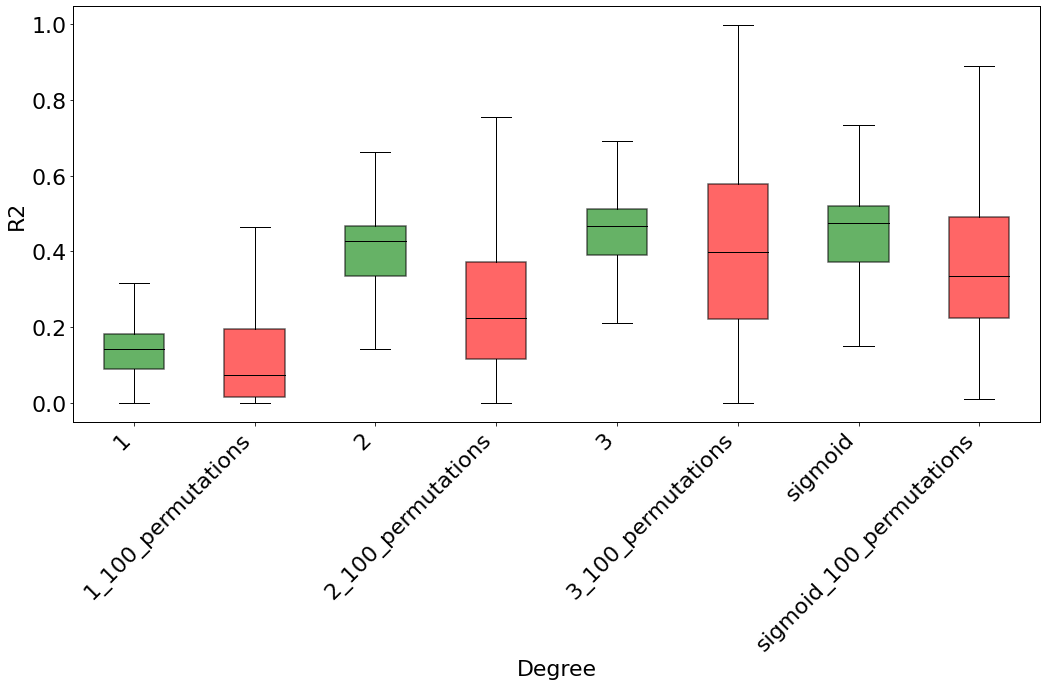

/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/ieo5417/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


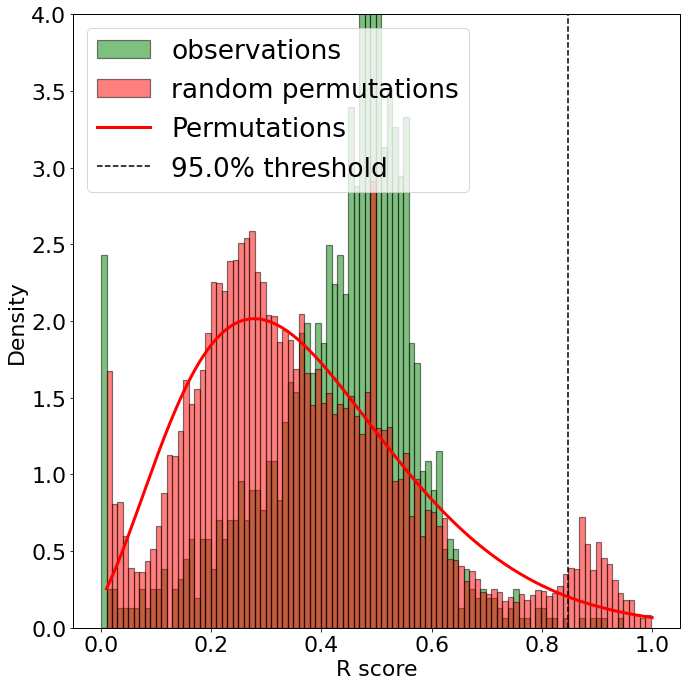

/home/ieo5417/.local/lib/python3.8/site-packages/statsmodels/stats/multitest.py:327: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha
/home/ieo5417/.local/lib/python3.8/site-packages/statsmodels/stats/multitest.py:333: RuntimeWarning: invalid value encountered in accumulate
  pvals_corrected = np.minimum.accumulate(pvals_corrected_raw[::-1])[::-1]
/home/ieo5417/.local/lib/python3.8/site-packages/statsmodels/stats/multitest.py:335: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1
/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/ieo5417/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.w

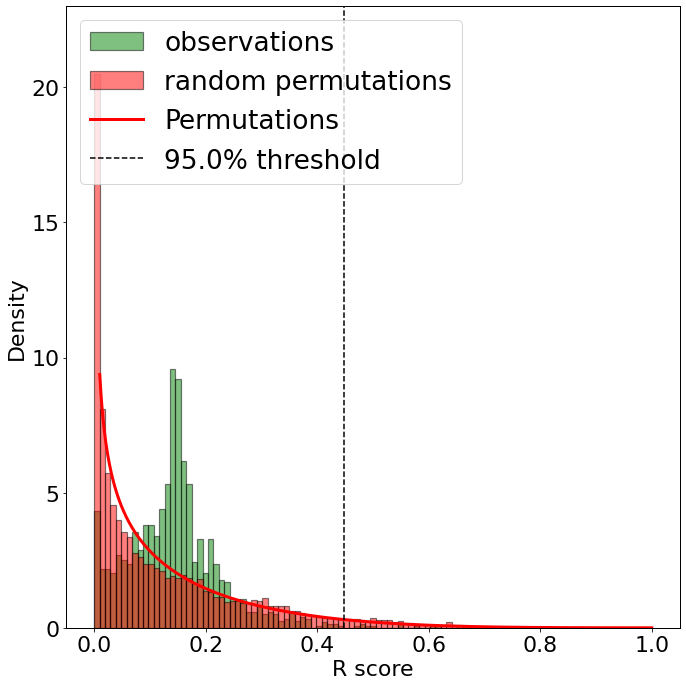

/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/ieo5417/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


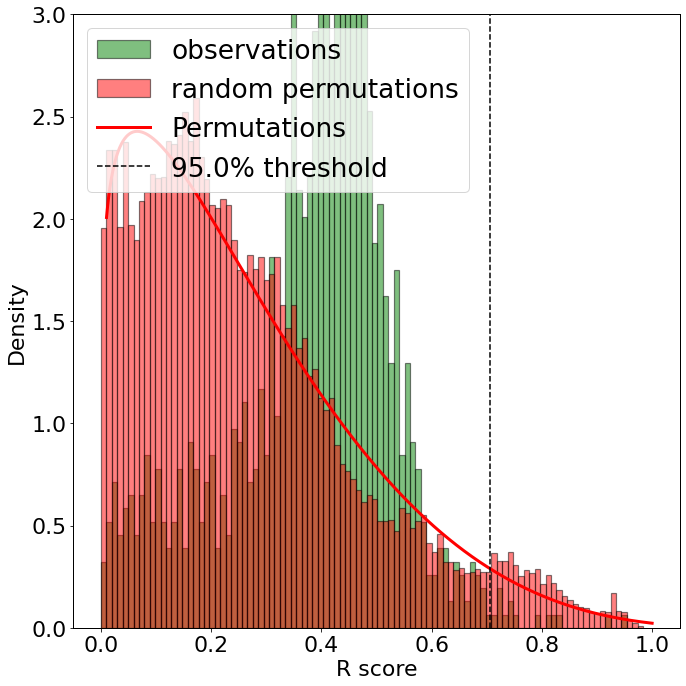

/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/ieo5417/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


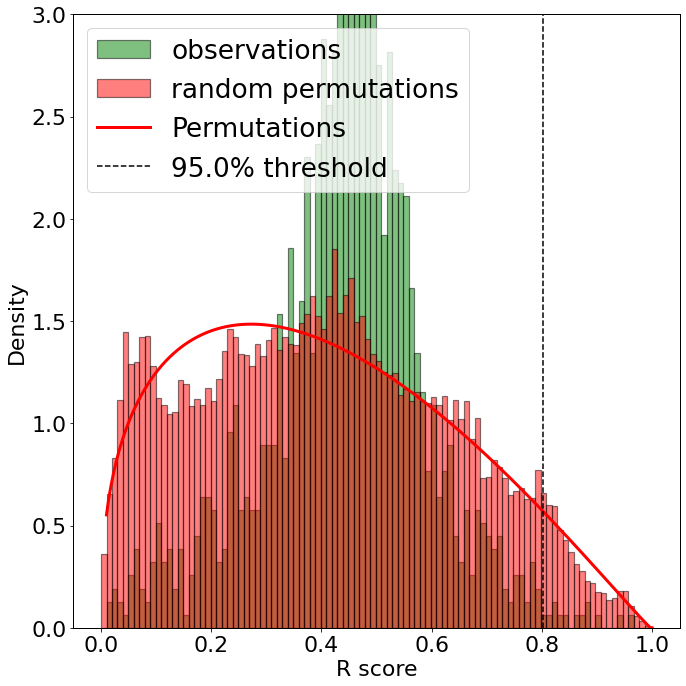

In [57]:
models_pvalue_mic, scores_table=pa_mic.plot_gof(poly_obs_scores_mic, sig_obs_scores_mic, poly_perm_scores_mic, sig_perm_scores_mic, dist_perm=True)

In [58]:
models_pvalue_mic

{'sigmoidal': [135813397.5, 1.3762558311724514e-88, 0.8474178354145601],
 1: [151579140.0, 2.978318815492766e-57, 0.4481534770839402],
 2: [178027167.5, 9.263097334226455e-206, 0.7049800072700834],
 3: [140352908.5, 1.9897071419792434e-22, 0.8026822880613228]}

In [59]:
poly_obs_scores_mic = select_significant_models(models_pvalue_mic, poly_obs_scores_mic)

In [60]:
col=[]
for column in poly_obs_scores_mic.columns:
    if column != 'sigmoidal': 
        col.append(int(column))
    else:
        col.append('sigmoidal')
poly_obs_scores_mic.columns = col

In [61]:
backgrounds_mic = assemble_backgrounds(poly_obs_scores_mic, sig_perm_scores_mic, poly_perm_scores_mic)

In [62]:
p_value_tables_mic = get_p_values(poly_obs_scores_mic, backgrounds_mic)

In [63]:
q_value_tables_mic = get_q_values(p_value_tables_mic, poly_obs_scores_mic)

/home/ieo5417/.local/lib/python3.8/site-packages/statsmodels/stats/multitest.py:327: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha
/home/ieo5417/.local/lib/python3.8/site-packages/statsmodels/stats/multitest.py:333: RuntimeWarning: invalid value encountered in accumulate
  pvals_corrected = np.minimum.accumulate(pvals_corrected_raw[::-1])[::-1]
/home/ieo5417/.local/lib/python3.8/site-packages/statsmodels/stats/multitest.py:335: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1


In [67]:
q_value_tables_mic.to_csv('prova.csv')

In [66]:
q_value_tables_mic

,1,2,3,sigmoidal
17.0,0.805134,0.5715,0.720165,0.524343
65552.0,0.805134,0.42845,0.70481,0.871786
24.0,0.805134,0.46522,0.70481,0.49845
51.0,0.814682,0.846916,0.820006,0.713139
180282.0,0.829637,0.586482,0.744834,0.930081
...,...,...,...,...
76489.0,0.805134,0.42845,0.70481,0.49845
52694.0,0.805134,0.42845,0.70481,0.50465
28227.0,0.805134,0.42845,0.70481,0.49845
82803.0,0.805134,0.42845,0.70481,0.500325


In [64]:
backgrounds_mic_str = {}
for key in backgrounds_mic.keys():
    backgrounds_mic_str[str(key)] = backgrounds_mic[key]

In [ ]:
classification_mic = classify_genes(poly_obs_scores_mic, q_value_tables_mic, 0.1, 0.1)

In [ ]:
q_value_tables_mic

In [ ]:
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in classification_mic.items() ])).to_csv('mic_classification.csv')

In [ ]:
classification_mic

# IMMUNE CELLS PROFILING

In [68]:
# Create workflow class, specifying the path to the SETTINGS.ini file
pa_imm = ProfileAnalysis('../../../docker/analysis/immune_cells')

Project has been created!


/home/ieo5417/Documenti/colon_paper/git/notebooks/paper_analysis/../../../git/lib/profile_analysis_class.py:156: UserWarning: Folder input_data already exist...skipping
  warnings.warn("Folder input_data already exist...skipping",
/home/ieo5417/Documenti/colon_paper/git/notebooks/paper_analysis/../../../git/lib/profile_analysis_class.py:162: UserWarning: Folder data_raw already exist...skipping
  warnings.warn("Folder data_raw already exist...skipping",
/home/ieo5417/Documenti/colon_paper/git/notebooks/paper_analysis/../../../git/lib/profile_analysis_class.py:168: UserWarning: Folder data_clinical already exist...skipping
  warnings.warn("Folder data_clinical already exist...skipping",
/home/ieo5417/Documenti/colon_paper/git/notebooks/paper_analysis/../../../git/lib/profile_analysis_class.py:174: UserWarning: Folder sample_by_section already exist...skipping
  warnings.warn("Folder sample_by_section already exist...skipping",
/home/ieo5417/Documenti/colon_paper/git/notebooks/paper_anal

## Assign each sample in clinical data file to a colon section

In [69]:
pa_imm.create_samples_to_sections_table()

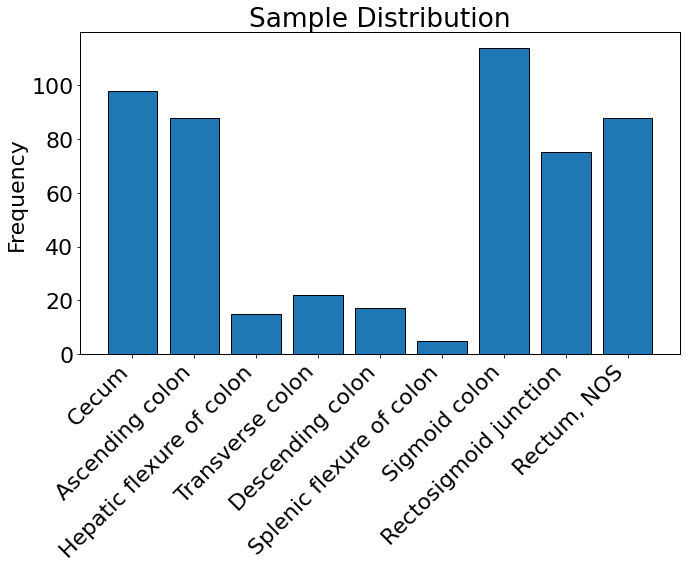

In [70]:
pa_imm.plot_sample_distribution()

## Calculate median value for each colon section

In [71]:
medians_imm, mad_imm = pa_imm.median_by_section()

This step has already been executed...loading results...
This step has already been executed...loading results...


In [ ]:
len(medians_imm)

In [ ]:
mad_imm.head()

## Fit Observables

In [72]:
scores_imm, poly_obs_scores_imm, sig_obs_scores_imm, poly_models_imm, sig_models_imm = pa_imm.fit_data(medians_imm, guess_bounds = True)

This step has already been executed...loading results...
This step has already been executed...loading results...
This step has already been executed...loading results...
This step has already been executed...loading results...


## Fit Random permutated data

In [73]:
poly_perm_scores_imm, sig_perm_scores_imm, sig_perm_models_imm=pa_imm.fit_random_data(medians_imm, guess_bounds = True)

This step has already been executed...loading results...
This step has already been executed...loading results...
This step has already been executed...loading results...


## Compare obrservable vs permutated data

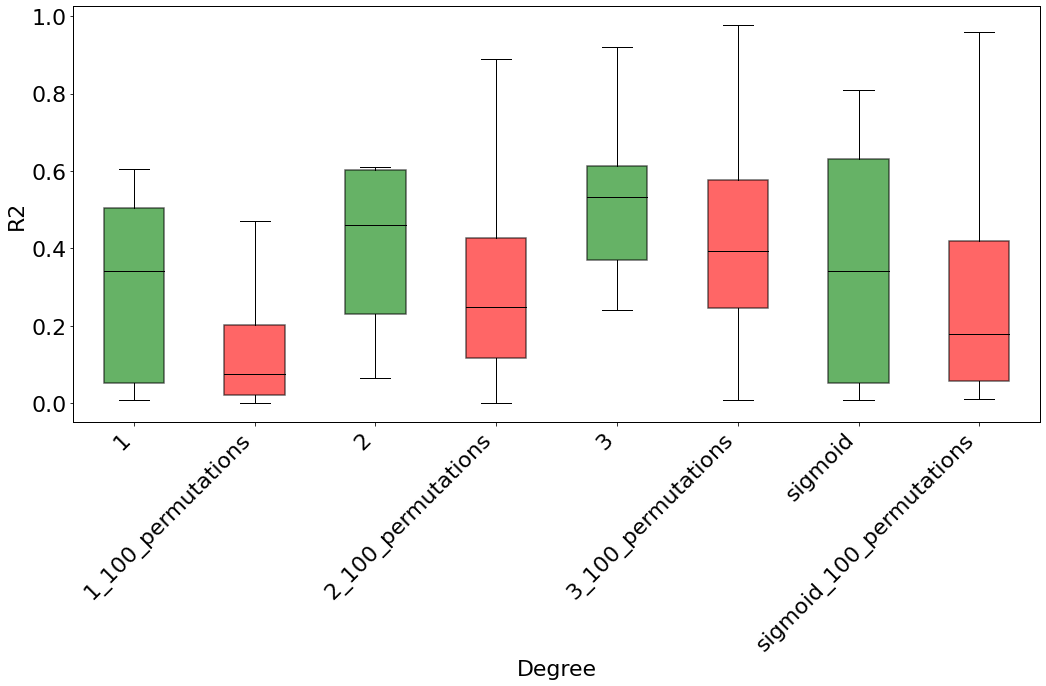

/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


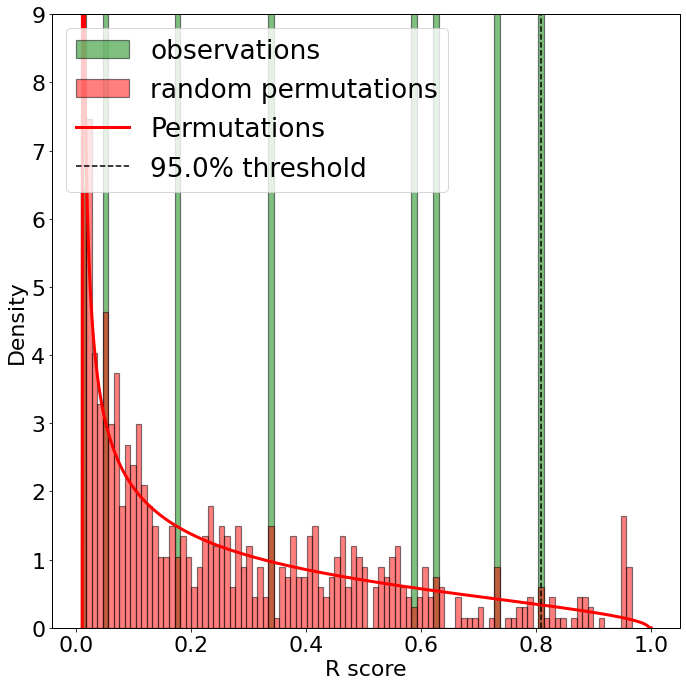

/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


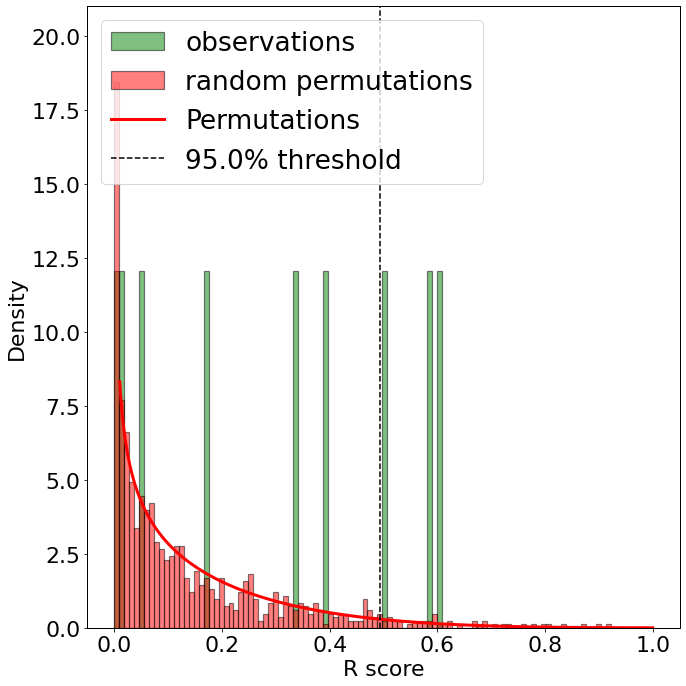

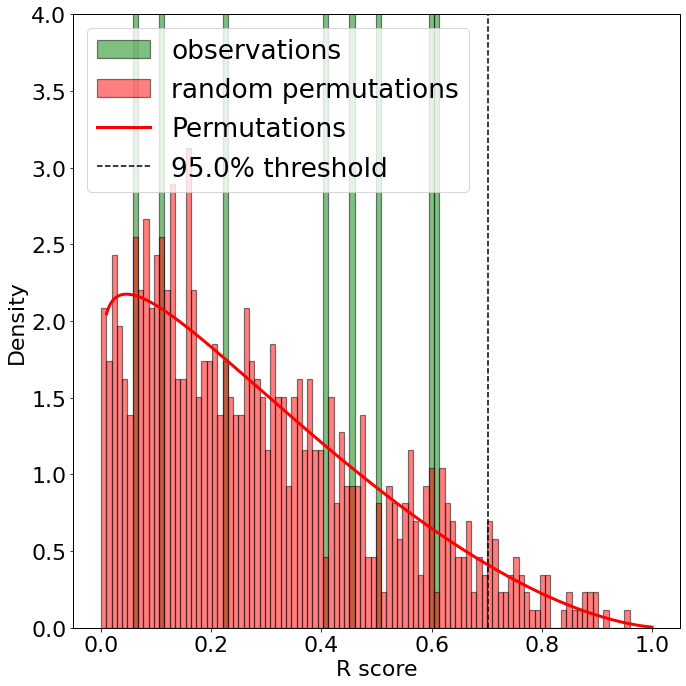

/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


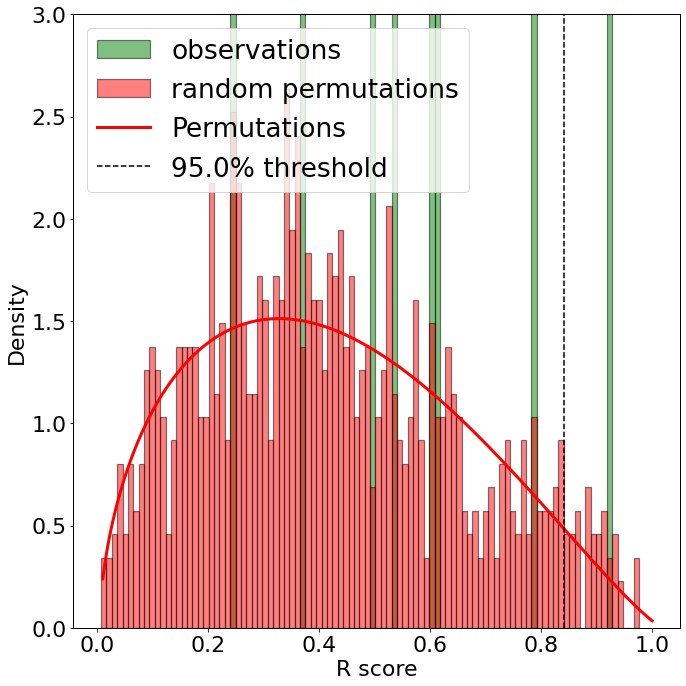

In [74]:
models_pvalue_imm, scores_table=pa_imm.plot_gof(poly_obs_scores_imm, sig_obs_scores_imm, poly_perm_scores_imm, sig_perm_scores_imm, dist_perm=True)

In [75]:
models_pvalue_imm

{'sigmoidal': [3570.0, 0.2433828513924995, 0.8084061471488586],
 1: [5540.0, 0.028683752848333424, 0.4930886981230882],
 2: [5253.0, 0.062476969704019975, 0.7030799177700063],
 3: [5198.0, 0.07157899842862023, 0.8405262850281643]}

In [76]:
poly_obs_scores_imm = select_significant_models(models_pvalue_imm, poly_obs_scores_imm)

In [77]:
backgrounds_imm = assemble_backgrounds(poly_obs_scores_imm, sig_perm_scores_imm, poly_perm_scores_imm)

In [78]:
p_value_tables_imm = get_p_values(poly_obs_scores_imm, backgrounds_imm)

In [79]:
q_value_tables_imm = get_q_values(p_value_tables_imm, poly_obs_scores_imm)

In [80]:
q_value_tables_imm[q_value_tables_imm[1]<0.2]

,1
T cells CD8,0.016404
T cells CD4 memory resting,0.196583
T cells follicular helper,0.017924
Macrophages M0,0.011191


In [81]:
backgrounds_imm_str = {}
for key in backgrounds_imm.keys():
    backgrounds_imm_str[str(key)] = backgrounds_imm[key]

In [83]:
classification_imm = classify_genes(poly_obs_scores_imm, q_value_tables_imm, 0.1, 0.1)

KeyError: ['sigmoidal']

In [ ]:
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in classification_imm.items() ])).to_csv('imm_classification.csv')

In [ ]:
for key in classification_imm:
    print(key)
    print(len(classification_imm[key]))

In [ ]:
classification_imm

## Cluster genes

In [ ]:
poly_obs_scores_imm = select_significant_models(models_pvalue_imm, poly_obs_scores_imm)

In [ ]:
backgrounds_imm = assemble_backgrounds(poly_obs_scores_imm, sig_perm_scores_imm, poly_perm_scores_imm)

In [ ]:
p_value_tables_imm = get_p_values(poly_obs_scores_imm, backgrounds_imm)

In [ ]:
q_value_tables_imm = get_q_values(p_value_tables_imm, poly_obs_scores_imm)

In [ ]:
classification_imm = classify_genes(poly_obs_scores_imm, q_value_tables_imm)

In [ ]:
classification_imm

In [ ]:
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in classification_imm.items() ])).to_csv('imm_classification.csv')

In [ ]:
genes_clusters_imm, genes_clusters_qs_imm=pa_imm.cluster_genes(scores_imm,scores_table)
sigmoid, continuous, discarded = pa_imm.classifyGenes(genes_clusters_qs_imm, scores_table)

In [ ]:
pa_imm.plot_clusters(genes_clusters_imm)

In [ ]:
summary_imm=pa_imm.get_summary_table(genes_clusters_imm, scores_imm)

In [ ]:
continuum_imm, sigmoid_imm, discarded_imm = pa_imm.classify_genes(summary_imm)

In [ ]:
pa_imm.plot_fitting(continuum_imm, continuum_imm.index, medians_imm, poly_models_imm, sig_models_imm, 'continuum', save_as='SF6.svg')

# METABOLITES PROFILING

In [ ]:
pa_met=ProfileAnalysis('../../../docker/analysis/metabolites')

## Assign each sample in clinical data file to a colon section

In [ ]:
pa_met.create_samples_to_sections_table()

# Figure 2C

In [ ]:
pa_met.plot_sample_distribution(title='IEO sample distribution')

# Figure 2B

In [ ]:
import numpy as np
labels = ['Sigmoid', 'Continuous']
metabolites = [0, 10]
microbiome = [0, 5]
immune = [0, 4]
sbs=[1, 1]

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(10,10))
rects3 = ax.bar(x - width/2, immune, width, label='Immune cells', edgecolor='k')
rects1 = ax.bar(x+width/2, metabolites, width, label='Metabolites', edgecolor='k')
rects2 = ax.bar(x+width*1.5, microbiome, width, label='Microbes', edgecolor='k')
rects4 = ax.bar(x - width*1.5, sbs, width, label='Mutational Signatures', edgecolor='k')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of features')
ax.set_xticks(x, labels)
ax.legend(loc='upper left')

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
ax.bar_label(rects4, padding=3)

fig.tight_layout()
# plt.savefig('/'.join([pa_met.figures, 'metabolites_microbes.svg']), format='svg')
plt.savefig('metabolites_microbes.svg', format='svg')
plt.show()

## Calculate median value for each colon section

In [ ]:
medians_met, mad_met=pa_met.median_by_section(remove_outliers=False, scale=False)

In [ ]:
medians_met = medians_met[medians_met.isna().sum(axis=1)<2]

In [ ]:
medians_met

In [ ]:
medians_met.fillna(0, inplace=True)

In [ ]:
medians_met = medians_met.loc[medians_met.median(axis=1)>1]

In [ ]:
medians_met

## Fit Observables

In [ ]:
models_scores_met, poly_obs_fit_scores_met, sig_obs_fit_scores_met, poly_models_met, sig_models_met=pa_met.fit_data(medians_met, guess_bounds = True)

## Fit Random permutated data

In [ ]:
poly_perm_fit_scores_met, sig_perm_fit_scores_met, sig_perm_models_met=pa_met.fit_random_data(medians_met, guess_bounds = True)

## Compare obrservable vs permutated data

In [ ]:
models_pvalue_table_met, scores_table=pa_met.plot_gof(poly_obs_fit_scores_met, sig_obs_fit_scores_met, poly_perm_fit_scores_met, sig_perm_fit_scores_met)

In [ ]:
models_pvalue_table_met

In [ ]:
# genes_clusters_met, genes_clusters_qs_met=pa_met.cluster_genes(models_scores_met,scores_table)
# sigmoid, continuous, discarded = pa_met.classifyGenes(genes_clusters_qs_met, scores_table)

In [ ]:
poly_obs_fit_scores_met = select_significant_models(models_pvalue_table_met, poly_obs_fit_scores_met)

In [ ]:
backgrounds_met = assemble_backgrounds(poly_obs_fit_scores_met, sig_perm_fit_scores_met, poly_perm_fit_scores_met)

In [ ]:
p_value_tables_met = get_p_values(poly_obs_fit_scores_met, backgrounds_met)

In [ ]:
q_value_tables_met = get_q_values(p_value_tables_met, poly_obs_fit_scores_met)

In [ ]:
backgrounds_met_str = {}
for key in backgrounds_met.keys():
    backgrounds_met_str[str(key)] = backgrounds_met[key]

In [ ]:
classification_met = classify_genes(poly_obs_fit_scores_met, q_value_tables_met, 0.1)

In [ ]:
q_value_tables_met[q_value_tables_met['1']<0.2]

In [ ]:
for key in classification_met:
    print(key)
    print(len(classification_met[key]))

In [ ]:
name_conversion = pd.read_csv('../../../docker/analysis/metabolites/metabolites_id_to_names.csv')
name_dict={}
for index in q_value_tables_met[q_value_tables_met[1]<0.2].index:
    name_dict[index]=name_conversion[name_conversion['CHEM_ID']==index]['CHEMICAL_NAME'].item()
metabolites_name_df=pd.DataFrame(name_dict, index=['metabolite name']).T

In [ ]:
metabolites_name_df

In [ ]:
plot_fitting_bars([197], medians_met, mad_met, poly_models_met, save_as='S-adenosylhomocysteine.svg')

In [ ]:
import math

def summary_profile_plot(medians, mad, indexes, metabolite_names, poly_models):
    if 'Unnamed: 0' in mad_met.columns:
        mad_met.set_index('Unnamed: 0', inplace=True)
    data=medians.loc[indexes]
    data_err=mad.loc[indexes]
    data.fillna(0, inplace=True)
    
    x = np.linspace(pa_met.x[0], pa_met.x[-1], 1000)
    degree = 1
    y = np.polynomial.polynomial.polyval(x, poly_models[degree][data.index[0]])
    
    n = 0    
    fig = plt.figure(figsize=(15, 15))
    axes=[]
    ax_base = plt.subplot2grid((9,2), (0,0))
    axes.append(ax_base)
    ax_base.errorbar(pa_met.x, data.loc[data.index[0]], yerr=data_err.loc[data.index[0]],
                     label=metabolite_names.loc[data.index[0]].item(),
                    marker='o', markeredgecolor='k', markerfacecolor='red', color='k')
    ax_base.plot(x, y, color='red', ls='-', linewidth=2, alpha=0.7)
    max_lim = math.ceil(data_err.loc[data.index[0]].max()+data.loc[data.index[0]].max())
    ax_base.axis(ymin=0, ymax=max_lim)
    ax_base.set_yticks([0, max_lim]) 
    ax_base.set_yticklabels([str(0), str(max_lim)], fontsize=15)
    ax_base.set_title(metabolite_names.loc[data.index[0]].item(), y=1.0, x=0.01, pad=-17, loc='left', fontsize=12)
    l=1
    h=0
    for index in data.index[1:len(data.index)]:
        degree = 1
        y = np.polynomial.polynomial.polyval(x, poly_models[degree][index])
        ax = plt.subplot2grid((9,2), (h,l), sharex=ax_base)
        axes.append(ax)
        markers, caps, bars = ax.errorbar(pa_met.x, data.loc[index], yerr=data_err.loc[index], label=metabolite_names.loc[index],
                    marker='o', markeredgecolor='k', markerfacecolor='red', color='k')
        ax.plot(x, y, color='red', ls='-', linewidth=2, alpha=0.7)
        ax.set_xticks(pa_met.x)
        ax.set_xticklabels(pa_met.sections4plots, rotation=45, ha='right', fontsize=15)
        max_lim = math.ceil(data_err.loc[index].max()+data.loc[index].max())
        ax.axis(ymin=0, ymax=max_lim)
        ax.set_yticks([0, max_lim])
        ax.set_yticklabels([str(0), str(max_lim)], fontsize=15)
        ax.set_title(metabolite_names.loc[index].item(), y=1.0, x=0.01, pad=-17, loc='left', fontsize=12)
        l = l+1
        if l == 2:
            h = h+1
            l = 0
    fig.subplots_adjust(hspace=0.25)   
    for ax in axes[0:-2]:
        plt.setp(ax.get_xticklabels(), visible=False)    
    plt.savefig('/'.join([pa_transcriptome.figures, 'continuous_metabolites.svg']), format='svg')

# Correlation metabolites/microbes

In [ ]:
metabolite_names = pd.read_csv('/home/ieo5417/Documenti/colon_paper/docker/analysis/metabolites/metabolites_id_to_names.csv')

metabolites_medians = medians_met.loc[q_value_tables_met[q_value_tables_met[1]<0.2].index]
metabolites_medians.fillna(0, inplace=True)

for index in metabolites_medians.index:
    metabolites_medians.loc[index, 'name'] = metabolite_names[metabolite_names['CHEM_ID']==index]['CHEMICAL_NAME'].item()
metabolites_medians.set_index('name', inplace=True)

In [ ]:
# microbes = pd.read_csv('/home/ieo5417/Documenti/colon_paper/docker/analysis/microbiome/output/continuum.csv')
# microbes.set_index('Unnamed: 0', inplace=True)
microbes_names = pd.read_csv('/home/ieo5417/Documenti/colon_paper/docker/analysis/microbiome/misc/all_species.txt', sep='\t')

# microbes_medians = pd.read_csv('/home/ieo5417/Documenti/colon_paper/docker/analysis/microbiome/sample_by_section_1/median_by_sections.csv')
# microbes_medians.set_index('Unnamed: 0', inplace=True)
microbes_medians = medians_mic.loc[q_value_tables_mic[q_value_tables_mic['1']<0.2].index]
microbes_medians.dropna(inplace=True)
for index in microbes_medians.index:
    if index in list(microbes_names['tax_id']):
        microbes_medians.loc[index, 'name'] = microbes_names[microbes_names['tax_id']==index]['taxon_name'].item()
microbes_medians.dropna(inplace=True)
microbes_medians.set_index('name', inplace=True)

In [ ]:
i=1
correlations = pd.DataFrame()
corr_mtrx = pd.DataFrame()
p_mtrx = pd.DataFrame()
for index_met, row_met in metabolites_medians.iterrows():
    for index_micro, row_micro in microbes_medians.iterrows():
#         temp=row_met.drop(['Splenic flexure of colon','Descending colon','Rectosigmoid junction'])
        stat,p = scipy.stats.pearsonr(row_met, row_micro)
        correlations.loc[i,'microbe'] = index_micro
        correlations.loc[i,'metabolite'] = index_met
        correlations.loc[i,'pearson'] = stat
        correlations.loc[i,'p-pearson'] = p
        corr_mtrx.loc[index_met,index_micro] = stat
        p_mtrx.loc[index_met,index_micro] = p
        stat,p = scipy.stats.spearmanr(row_met, row_micro)
        correlations.loc[i,'spearman'] = stat
        correlations.loc[i,'p-spearman'] = p
        correlations.loc[i,'genus'] = index_micro.split('_')[0]
        i=i+1
correlations['q-value'] = fdrcorrection(correlations['p-pearson'])[1]

In [ ]:
correlations.to_csv('correlations.csv')

In [ ]:
p_mtrx.to_csv('p_prsn_mtrx.csv')

In [ ]:
summary_profile_plot(medians_met, mad_met, metabolites_name_df.index, metabolites_name_df, poly_models_met)

In [ ]:
left=pa_met.samples2sections['Cecum']+pa_met.samples2sections['Ascending colon']+pa_met.samples2sections['Hepatic flexure of colon']+pa_met.samples2sections['Splenic flexure of colon']
right=pa_met.samples2sections['Descending colon']+pa_met.samples2sections['Sigmoid colon']+pa_met.samples2sections['Rectosigmoid junction']+pa_met.samples2sections['Rectum, NOS']

In [ ]:
classification_mf

# Figure 2D

In [ ]:
profiling_results = {}
unclassified_tr=len(medians_tr)-len(classification_tr['continuous'])-len(classification_tr['sigmoid'])
profiling_results['RNA-seq'] = [len(classification_tr['continuous']),len(classification_tr['sigmoid']),unclassified_tr]

unclassified_meth=len(medians_meth)-len(classification_meth['continuous'])-len(classification_meth['sigmoid'])
profiling_results['Methylation'] = [len(classification_meth['continuous']),len(classification_meth['sigmoid']),unclassified_meth]

unclassified_mut=len(medians_mut)-len(classification_mut['continuous'])-len(classification_mut['sigmoid'])
profiling_results['SNV'] = [len(classification_mut['continuous']),len(classification_mut['sigmoid']),unclassified_mut]

unclassified_dup=len(medians_dup)-len(q_value_tables_dup[q_value_tables_dup['1']<0.2])-0
unclassified_del=len(medians_del)-len(classification_del['continuous'])-len(classification_del['sigmoid'])
profiling_results['Aneuploidy'] = [len(q_value_tables_dup[q_value_tables_dup['1']<0.2])+len(classification_del['continuous']),
                                   0+len(classification_del['sigmoid']),
                                   unclassified_dup+unclassified_del]

unclassified_cms=len(medians_cms)-len(classification_cms['continuous'])-len(classification_cms['sigmoid'])
profiling_results['CMS'] = [len(classification_cms['continuous']),len(classification_cms['sigmoid']),unclassified_cms]

unclassified_mf=len(medians_mf)-len(classification_mf['continuous'])-len(classification_mf['sigmoid'])
profiling_results['Molecular Subtypes'] = [len(classification_mf['continuous']),len(classification_mf['sigmoid']),unclassified_mf]

# Figure 1C

In [ ]:
from textwrap import wrap

cm = 1/2.54  # centimeters in inches
l=0
h=0
wedgeprops = {'width':0.3, 'edgecolor':'black', 'linewidth':2}
colors = ['#0b55cc', '#f1c232','#808080']
fig = plt.figure(figsize=(13*cm, 6*cm))
names = ['Continuous', 'Sigmoid', 'Unclassified']

for key in profiling_results:
    ax = plt.subplot2grid((2,5), (h,l))
    cont = profiling_results[key][0]
    sig = profiling_results[key][1]
    unc = profiling_results[key][2]
    wedges, texts= ax.pie([cont, sig, unc], wedgeprops=wedgeprops, colors=colors,
                                  textprops=dict(color="k"),startangle=180)

    ax.set_title('\n'.join(wrap(key,11)), fontsize=10, loc='center', pad=1)
    l = l+1
    if l == 3:
        h = h+1
        l = 0
ax.legend(wedges, names,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1), prop={'size': 10}, framealpha=0)
plt.savefig('/'.join([pa_mic.figures, 'Feature_Summary.svg']), format='svg')

In [ ]:
'/'.join([pa_mic.figures, 'Feature_Summary.svg'])

# NETWORK ANALYSIS

In [3]:
biopax_path = '../../../docker/analysis/network_analysis_COAD_READ/biopax'
graphml_path = '../../../docker/analysis/network_analysis_COAD_READ/graphml'
metabolites_path = '../../../docker/analysis/network_analysis_COAD_READ/input_data/input_metabolites.csv'
genes_path = '../../../docker/analysis/transcriptome/output/sigmoid_coding.csv'
# genes_path = '../../../docker/analysis/transcriptome/output/sigmoid_genes_list.txt'

NSA=NetworkSearchAnalysis(graphml_path, biopax_path, metabolites_path, genes_path)

In [4]:
print('mapping genes to pathway...')
NSA.gene2pathways, NSA.uniprot2ensmbl, NSA.reactome2pathway_names = NSA.map_genes2pathways(NSA.gene_list, scopes='ensemblgene')
print('done!')
print('loading pathways...')
pathways_to_load = [x for x in set(sum(NSA.gene2pathways.values(), []))]
NSA.pathways_graphs, NSA.directed_graph = NSA.load_pathways(pathways_to_load)
NSA.reactome2chebi, NSA.reactome2nodeid_chebi = NSA.map_chebi_to_pathway(NSA.pathways_graphs)
print('done!')
print('select metabolites to analyze')
NSA.target_chebis2pathways = NSA.findTargetChebiInPathways(NSA.reactome2chebi, NSA.metabolites_dict)
print('done!')
print('get metabolites networks ids...')
NSA.ids_to_analyze = NSA.mapIdToAnalyze(NSA.target_chebis2pathways, NSA.reactome2nodeid_chebi)
print('done!')
print('create random test statistics distributions...')
NSA.random_t_stats = NSA.calculate_random_t_stats(NSA.ids_to_analyze, NSA.pathways_graphs)
print('done!')
print('calculate test statistics of observables...')
NSA.pathways_distances_uniprot, NSA.pathway_test_statistics = NSA.calculate_t_stats(NSA.ids_to_analyze, NSA.pathways_graphs)
print('done!')
print('fitting random test statistics distributions...')
NSA.fitting = NSA.fit_distribution(NSA.random_t_stats)
print('done!')
print('get valid genes...')
NSA.pathway_dist, NSA.pdfs = NSA.get_pathway_dist(NSA.random_t_stats, NSA.fitting)
print('done!')
print('calculate p-values ...')
NSA.statistics_df, NSA.p_tresh = NSA.get_p_value(NSA.pathway_dist, NSA.pathway_test_statistics)
print('done!')
print('generate results...')
NSA.final_table = NSA.make_results_table(NSA.statistics_df, NSA.pathways_distances_uniprot)
print('finished!')

mapping genes to pathway...
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-2868...done.
Finished.
1 input query terms found no hit:
	['ENSG00000168078']
done!
loading pathways...
pathway R-HSA-9823730 not found!
pathway R-HSA-9752946 not found!
pathway R-HSA-9764260 not found!
pathway R-HSA-9833576 not found!
pathway R-HSA-9824272 not found!
pathway R-HSA-9824443 not found!
pathway R-HSA-9759476 not found!
pathway R-HSA-8874177 not found!
pathway R-HSA-9764302 not found!
pathway R-HSA-9824439 not found!
pathway R-HSA-9733709 not found!
pathway R-HSA-9759475 not found!
pathway R-HSA-9824446 not found!
pathway R-HSA-9772755 not found!
pathway R-HSA-9732724 not found!
pathway R-HSA-9762292 not found!
pathway R-HSA-9827857 not found!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:1027: RuntimeWarning: overflow encountered in power
  - sc.xlog1py(d_+1, x_**(-c_))))


done!
get valid genes...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:1045: RuntimeWarning: overflow encountered in power
  return (q**(-1.0/d) - 1)**(-1.0/c)
/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:1014: RuntimeWarning: overflow encountered in power
  f2 = lambda x_, c_, d_: (c_ * d_ * (x_ ** (-c_ - 1.0)) /
/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:1014: RuntimeWarning: overflow encountered in multiply
  f2 = lambda x_, c_, d_: (c_ * d_ * (x_ ** (-c_ - 1.0)) /
/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:1015: RuntimeWarning: overflow encountered in power
  ((1 + x_ ** (-c_)) ** (d_ + 1.0))))
/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:1014: RuntimeWarning: invalid value encountered in divide
  f2 = lambda x_, c_, d_: (c_ * d_ * (x_ ** (-c_ - 1.0)) /


done!
calculate p-values ...
done!
generate results...
finished!


In [5]:
NSA.final_table.to_csv('sigmoid_coding_final.csv')

In [ ]:
def make_results_table(statistics_df, pathways_distances_uniprot):
    significant_pathways_continuum = pd.DataFrame(columns=['pathway_id',
                                                  'pathway_name', 'metabolite', 'genes_uniprot',
                                                  'genes_symbol', 'q_value'])
    i=0
    for pathway in statistics_df[statistics_df['q_value'] <= 0.2].index:
        for keys in pathways_distances_uniprot.keys():
            if (pathway in keys) and (pathways_distances_uniprot[keys]):
                significant_pathways_continuum.loc[i, 'pathway_id'] = pathway
                significant_pathways_continuum.loc[i, 'pathway_name'] = NSA.reactome2pathway_names[pathway]
                significant_pathways_continuum.at[i, 'metabolite'] = keys[1]
                significant_pathways_continuum.at[i, 'genes_uniprot'] = pathways_distances_uniprot[keys]
                symbols = []
#                 for gene in pathways_distances_uniprot[keys]:
#                     symbols.append(NSA.uniprot2symbol[gene])
#                 significant_pathways_continuum.at[i, 'genes_symbol'] = symbols
                significant_pathways_continuum.at[i, 'q_value'] = statistics_df.loc[pathway, 'q_value']
                i=i+1
    return significant_pathways_continuum

In [ ]:
import pandas as pd
NSA.final_table = NSA.make_results_table(NSA.statistics_df, NSA.pathways_distances_uniprot)
print('finished!')

In [19]:
for index, row in NSA.final_table.iterrows():
    temp_l = ''
    for element in row['genes_uniprot']:
        if temp_l:
            temp_l =temp_l+f', {element}'
        else:
            temp_l = temp_l+element
    NSA.final_table.loc[index, 'genes_uniprot'] = temp_l

In [ ]:
# NSA.final_table.to_csv('network_analysis_table_methylation_1000.csv')
NSA.final_table.to_csv('network_analysis_table_transcriptomic_GTEX_100_iter_sig_NEW.csv')

In [20]:
summary_groups = NSA.final_table.groupby(['metabolite','genes_uniprot'])
summary_table = pd.DataFrame()
for name, group in summary_groups:
    counter = collections.Counter(group['genes_uniprot'])
#     print(counter)
    for element in counter:
        if counter[element] > 1:
            rows_to_summarize = group[group['genes_uniprot']==element]
            row_to_keep = rows_to_summarize['q_value'].min()
            summary_table = pd.concat([summary_table, rows_to_summarize[rows_to_summarize['q_value']==row_to_keep]])
        else:
            summary_table = pd.concat([summary_table, group[group['genes_uniprot']==element]])
summary_table.to_csv('network_analysis_summary_sig_NEW.csv')

In [21]:
NSA.final_table

,pathway_id,pathway_name,metabolite,genes_uniprot,genes_symbol,q_value
0,R-HSA-192105,Synthesis of bile acids and bile salts,CHEBI:17500,Q96RI1,NaN,0.018484
1,R-HSA-192105,Synthesis of bile acids and bile salts,CHEBI:16027,Q9Y2P5,NaN,0.018484
2,R-HSA-192105,Synthesis of bile acids and bile salts,CHEBI:16755;CHEBI:16325;CHEBI:28834,Q96RI1,NaN,0.018484
3,R-HSA-212165,Epigenetic regulation of gene expression,CHEBI:16680,"Q92769, Q9Y6K1, Q16777, Q16778, O94776, P68431",NaN,0.126206
4,R-HSA-983169,Class I MHC mediated antigen processing & pres...,CHEBI:16027,"Q9HCE7, Q7Z6J0, O00762, Q9Y252, Q96KE9, Q9H4P4...",NaN,0.0
5,R-HSA-194068,Bile acid and bile salt metabolism,CHEBI:17500,Q96RI1,NaN,0.126206
6,R-HSA-194068,Bile acid and bile salt metabolism,CHEBI:16027,Q9Y2P5,NaN,0.126206
7,R-HSA-194068,Bile acid and bile salt metabolism,CHEBI:16755;CHEBI:16325;CHEBI:28834,Q96RI1,NaN,0.126206
8,R-HSA-194068,Bile acid and bile salt metabolism,CHEBI:28865;CHEBI:17687;CHEBI:16359;CHEBI:1675...,"Q96RI1, P51161",NaN,0.126206
9,R-HSA-194068,Bile acid and bile salt metabolism,CHEBI:16359;CHEBI:16755,Q9Y2P5,NaN,0.126206


# SANITY CHECKS

In [84]:
import glob
random_lists = glob.glob('/home/ieo5417/Documenti/colon_paper/docker/analysis/metabolites/random_lists/*csv')
genes_path = '../../../docker/analysis/transcriptome/output/sigmoid_coding.csv'
metabolites_path = '../../../docker/analysis/network_analysis_COAD_READ/input_data/input_metabolites.csv'
NSA = NetworkSearchAnalysis(graphml_path, biopax_path, metabolites_path, genes_path)
print('mapping genes to pathway...')
NSA.gene2pathways, NSA.uniprot2ensmbl, NSA.reactome2pathway_names = NSA.map_genes2pathways(NSA.gene_list, scopes='ensemblgene')
print('done!')
print('loading pathways...')
pathways_to_load = [x for x in set(sum(NSA.gene2pathways.values(), []))]
NSA.pathways_graphs, NSA.directed_graph = NSA.load_pathways(pathways_to_load)
print('done!')

mapping genes to pathway...
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-2868...done.
Finished.
1 input query terms found no hit:
	['ENSG00000168078']
done!
loading pathways...
pathway R-HSA-9823730 not found!
pathway R-HSA-9752946 not found!
pathway R-HSA-9764260 not found!
pathway R-HSA-9833576 not found!
pathway R-HSA-9824272 not found!
pathway R-HSA-9824443 not found!
pathway R-HSA-9759476 not found!
pathway R-HSA-8874177 not found!
pathway R-HSA-9764302 not found!
pathway R-HSA-9824439 not found!
pathway R-HSA-9733709 not found!
pathway R-HSA-9759475 not found!
pathway R-HSA-9824446 not found!
pathway R-HSA-9772755 not found!
pathway R-HSA-9732724 not found!
pathway R-HSA-9762292 not found!
pathway R-HSA-9827857 not found!
done!


In [ ]:
for rlist in random_lists:
    try:
        filename=rlist.split('_')[-1].split('.')[0]
        NSA.metabolites_path = rlist
        NSA.reactome2chebi, NSA.reactome2nodeid_chebi = NSA.map_chebi_to_pathway(NSA.pathways_graphs)
        print('done!')
        print('select metabolites to analyze')
        NSA.target_chebis2pathways = NSA.findTargetChebiInPathways(NSA.reactome2chebi, NSA.metabolites_dict)
        print('done!')
        print('get metabolites networks ids...')
        NSA.ids_to_analyze = NSA.mapIdToAnalyze(NSA.target_chebis2pathways, NSA.reactome2nodeid_chebi)
        print('done!')
        print('create random test statistics distributions...')
        NSA.random_t_stats = NSA.calculate_random_t_stats(NSA.ids_to_analyze, NSA.pathways_graphs)
        print('done!')
        print('calculate test statistics of observables...')
        NSA.pathways_distances_uniprot, NSA.pathway_test_statistics = NSA.calculate_t_stats(NSA.ids_to_analyze, NSA.pathways_graphs)
        print('done!')
        print('fitting random test statistics distributions...')
        NSA.fitting = NSA.fit_distribution(NSA.random_t_stats)
        print('done!')
        print('get valid genes...')
        NSA.pathway_dist, NSA.pdfs = NSA.get_pathway_dist(NSA.random_t_stats, NSA.fitting)
        print('done!')
        print('calculate p-values ...')
        NSA.statistics_df, NSA.p_tresh = NSA.get_p_value(NSA.pathway_dist, NSA.pathway_test_statistics)
        print('done!')
        print('generate results...')
        NSA.final_table = NSA.make_results_table(NSA.statistics_df, NSA.pathways_distances_uniprot)
        print('finished!')
        
        for index, row in NSA.final_table.iterrows():
            temp_l = ''
            for element in row['genes_uniprot']:
                if temp_l:
                    temp_l =temp_l+f', {element}'
                else:
                    temp_l = temp_l+element
            NSA.final_table.loc[index, 'genes_uniprot'] = temp_l
        NSA.final_table.to_csv(f'/home/ieo5417/Documenti/colon_paper/docker/analysis/metabolites/random_list_results_sigmoid/random_list_{filename}_results_RAW.csv')
        summary_groups = NSA.final_table.groupby(['metabolite','genes_uniprot'])
        summary_table = pd.DataFrame()
        for name, group in summary_groups:
            counter = collections.Counter(group['genes_uniprot'])
        #     print(counter)
            for element in counter:
                if counter[element] > 1:
                    rows_to_summarize = group[group['genes_uniprot']==element]
                    row_to_keep = rows_to_summarize['q_value'].min()
                    summary_table = pd.concat([summary_table, rows_to_summarize[rows_to_summarize['q_value']==row_to_keep]])
                else:
                    summary_table = pd.concat([summary_table, group[group['genes_uniprot']==element]])
        summary_table.drop_duplicates(subset=['pathway_name'],inplace=True)
        summary_table.to_csv(f'/home/ieo5417/Documenti/colon_paper/docker/analysis/metabolites/random_list_results_sigmoid/random_list_{filename}_results.csv')
    except Exception:
        pass

done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


done!
get valid genes...
done!
calculate p-values ...
done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


done!
get valid genes...
done!
calculate p-values ...
done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


done!
get valid genes...
done!
calculate p-values ...
done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


done!
get valid genes...
done!
calculate p-values ...
done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


done!
get valid genes...
done!
calculate p-values ...
done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


done!
get valid genes...
done!
calculate p-values ...
done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


done!
get valid genes...
done!
calculate p-values ...
done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


done!
get valid genes...
done!
calculate p-values ...
done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


done!
get valid genes...
done!
calculate p-values ...
done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:1027: RuntimeWarning: overflow encountered in power
  - sc.xlog1py(d_+1, x_**(-c_))))


done!
get valid genes...
done!
calculate p-values ...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:1045: RuntimeWarning: overflow encountered in power
  return (q**(-1.0/d) - 1)**(-1.0/c)
/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:1014: RuntimeWarning: overflow encountered in power
  f2 = lambda x_, c_, d_: (c_ * d_ * (x_ ** (-c_ - 1.0)) /
/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:1014: RuntimeWarning: overflow encountered in multiply
  f2 = lambda x_, c_, d_: (c_ * d_ * (x_ ** (-c_ - 1.0)) /
/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:1015: RuntimeWarning: overflow encountered in power
  ((1 + x_ ** (-c_)) ** (d_ + 1.0))))
/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:1014: RuntimeWarning: invalid value encountered in divide
  f2 = lambda x_, c_, d_: (c_ * d_ * (x_ ** (-c_ - 1.0)) /


done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


done!
get valid genes...
done!
calculate p-values ...
done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


done!
get valid genes...
done!
calculate p-values ...
done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


done!
get valid genes...
done!
calculate p-values ...
done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


done!
get valid genes...
done!
calculate p-values ...
done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


done!
get valid genes...
done!
calculate p-values ...
done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


done!
get valid genes...
done!
calculate p-values ...
done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


done!
get valid genes...
done!
calculate p-values ...
done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


done!
get valid genes...
done!
calculate p-values ...
done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


done!
get valid genes...
done!
calculate p-values ...
done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


done!
get valid genes...
done!
calculate p-values ...
done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


done!
get valid genes...
done!
calculate p-values ...
done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


done!
get valid genes...
done!
calculate p-values ...
done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


done!
get valid genes...
done!
calculate p-values ...
done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


done!
get valid genes...
done!
calculate p-values ...
done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


done!
get valid genes...
done!
calculate p-values ...
done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


done!
get valid genes...
done!
calculate p-values ...
done!
generate results...
finished!
done!
select metabolites to analyze
done!
get metabolites networks ids...
done!
create random test statistics distributions...
done!
calculate test statistics of observables...
done!
fitting random test statistics distributions...


/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


In [ ]:
NSA.final_table['g_m'] = ''
NSA.final_table = NSA.final_table.astype(object)
for index, row in NSA.final_table.iterrows():
    g_m = []
    g_m = g_m + row['metabolite'].split(';') + row['genes_uniprot'].split(',')
    NSA.final_table.at[index,'g_m'] = sorted(g_m)
df = NSA.final_table
groups = df.groupby(df['g_m'].map(tuple))
results = pd.DataFrame()
for name, group in groups:
    results = pd.concat([results, group.sort_values('q_value').iloc[0,:]], axis=1)
results = results.T.sort_values('pathway_id')
results.drop('g_m', axis=1, inplace=True)

In [ ]:
results.to_csv('final_summary.csv')

In [ ]:
files = glob.glob('/home/ieo5417/Documenti/colon_paper/docker/analysis/metabolites/random_list_results/*RAW.csv')
for file in files:
    filename='_'.join(file.split('/')[-1].split('_')[0:-1])
    data = pd.read_csv(file)
    data.drop('Unnamed: 0', axis=1, inplace=True)
    data['g_m'] = ''
    data = data.astype(object)
    for index, row in data.iterrows():
        g_m = []
        g_m = g_m + row['metabolite'].split(';') + row['genes_uniprot'].split(',')
        data.at[index,'g_m'] = sorted(g_m)
    df = data
    groups = df.groupby(df['g_m'].map(tuple))
    results = pd.DataFrame()
    for name, group in groups:
        results = pd.concat([results, group.sort_values('q_value').iloc[0,:]], axis=1)
    if len(results)>0:
        results = results.T.sort_values('pathway_id')
        results.drop('g_m', axis=1, inplace=True)
    results.to_csv(f'/home/ieo5417/Documenti/colon_paper/docker/analysis/metabolites/random_list_results/{filename}_new.csv')    

In [ ]:
filename

In [ ]:
import glob
import collections
import matplotlib.pyplot as plt
results=glob.glob('/home/ieo5417/Documenti/colon_paper/docker/analysis/metabolites/random_list_results/*_new.csv')
pathway_found=[]
n_pathway = []
for path in results:
    data=pd.read_csv(path)
    if not data.empty:
        pathway_found=pathway_found+list(data['pathway_name'].unique())
        n_pathway.append(len(data['pathway_name'].unique()))
    else:
        n_pathway.append(0)
counter = collections.Counter(pathway_found)
df = pd.DataFrame.from_dict([counter]).T
df.sort_values(by=[0], inplace=True, ascending=False)
plt.figure(figsize=(20,10))
plt.bar(range(0,len(df.index)),df[0])
# plt.bar(counter.keys(), counter.values())
columns = list(d[:39] for d in df.index)
plt.xticks(range(0,len(df.index)),range(0,len(df.index)),rotation = 45, ha='right', fontsize=14)
plt.ylabel('Frequency (%)')
plt.tight_layout()
plt.savefig('pathway_found.svg', format='svg')

In [ ]:
counter_n = collections.Counter(n_pathway)
df = pd.DataFrame.from_dict([counter_n]).T
df.sort_index(inplace=True)
plt.figure(figsize=(15,10))
plt.bar(range(0,len(df.index)),df[0], color='gray', edgecolor='black')
plt.xticks(range(0,20),range(0,20), fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel('Frequency (%)', fontsize=22)
plt.xlabel('Number of pathways found', fontsize=22)
plt.tight_layout()
plt.savefig('frequency_of_pathway_found.svg', format='svg')

In [6]:
sig = pd.read_csv('/home/ieo5417/Documenti/colon_paper/git/notebooks/paper_analysis/sigmoid_coding_final.csv')
cont = pd.read_csv('/home/ieo5417/Documenti/colon_paper/git/notebooks/paper_analysis/continuum_coding_final.csv')

In [7]:
sig

,Unnamed: 0,pathway_id,pathway_name,metabolite,genes_uniprot,genes_symbol,q_value
0,0,R-HSA-192105,Synthesis of bile acids and bile salts,CHEBI:17500,['Q96RI1'],NaN,0.018484
1,1,R-HSA-192105,Synthesis of bile acids and bile salts,CHEBI:16027,['Q9Y2P5'],NaN,0.018484
2,2,R-HSA-192105,Synthesis of bile acids and bile salts,CHEBI:16755;CHEBI:16325;CHEBI:28834,['Q96RI1'],NaN,0.018484
3,3,R-HSA-212165,Epigenetic regulation of gene expression,CHEBI:16680,"['Q92769', 'Q9Y6K1', 'Q16777', 'Q16778', 'O947...",NaN,0.126206
4,4,R-HSA-983169,Class I MHC mediated antigen processing & pres...,CHEBI:16027,"['Q9HCE7', 'Q7Z6J0', 'O00762', 'Q9Y252', 'Q96K...",NaN,0.000000
5,5,R-HSA-194068,Bile acid and bile salt metabolism,CHEBI:17500,['Q96RI1'],NaN,0.126206
6,6,R-HSA-194068,Bile acid and bile salt metabolism,CHEBI:16027,['Q9Y2P5'],NaN,0.126206
7,7,R-HSA-194068,Bile acid and bile salt metabolism,CHEBI:16755;CHEBI:16325;CHEBI:28834,['Q96RI1'],NaN,0.126206
8,8,R-HSA-194068,Bile acid and bile salt metabolism,CHEBI:28865;CHEBI:17687;CHEBI:16359;CHEBI:1675...,"['Q96RI1', 'P51161']",NaN,0.126206
9,9,R-HSA-194068,Bile acid and bile salt metabolism,CHEBI:16359;CHEBI:16755,['Q9Y2P5'],NaN,0.126206


In [16]:
only_cont =pd.DataFrame()
for index,row in cont.iterrows():
    if not row['pathway_name'] in list(sig['pathway_name']):
        only_cont = pd.concat([only_cont, row], axis=1)
only_cont = only_cont.T

In [18]:
only_cont.to_csv('only_continuous_pathway.csv')

# END